In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


##Dataset

In [3]:
df =pd.read_csv('application_train.csv')
print('dataset ini memiliki %d baris dan %d kolom.\n' %df.shape)
df.head(10)

dataset ini memiliki 194129 baris dan 122 kolom.



,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
7,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,100011,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,100012,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


## Explanatory Data Analysis (EDA)

check datatypes

In [4]:
print('Data type:\n')
df.info(verbose=True)

Data type:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194129 entries, 0 to 194128
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    floa

In [5]:
train = df.copy()

## Univariate

In [6]:
decode_map = {0:"No payment Difficulties", 1:"Have Payment Difficulties"}
def decode_sentiment(label):
  return decode_map[int(label)]

train["TARGET"]=train["TARGET"].map(decode_map)

In [7]:
target_grp = (train.groupby("TARGET")
              .agg(COUNT=('TARGET', 'count'))
              .sort_values(by=["COUNT"],ascending = False)
              .reset_index())
target_grp = target_grp.assign(PERCENTAGE = (target_grp["COUNT"]/len(train)*100).round(2))
target_grp.style \
.background_gradient(cmap="Greens") \
.format({'PERCENTAGE' : '{:.2f}%'})

,TARGET,COUNT,PERCENTAGE
0,No payment Difficulties,178357,91.88%
1,Have Payment Difficulties,15772,8.12%


In [8]:
grp = (train['TARGET'].value_counts(normalize=True) *100).round(2)
grp.reset_index().style.background_gradient(cmap='Greens').format({'proportion': '{:.2f}%'})

,TARGET,proportion
0,No payment Difficulties,91.88%
1,Have Payment Difficulties,8.12%


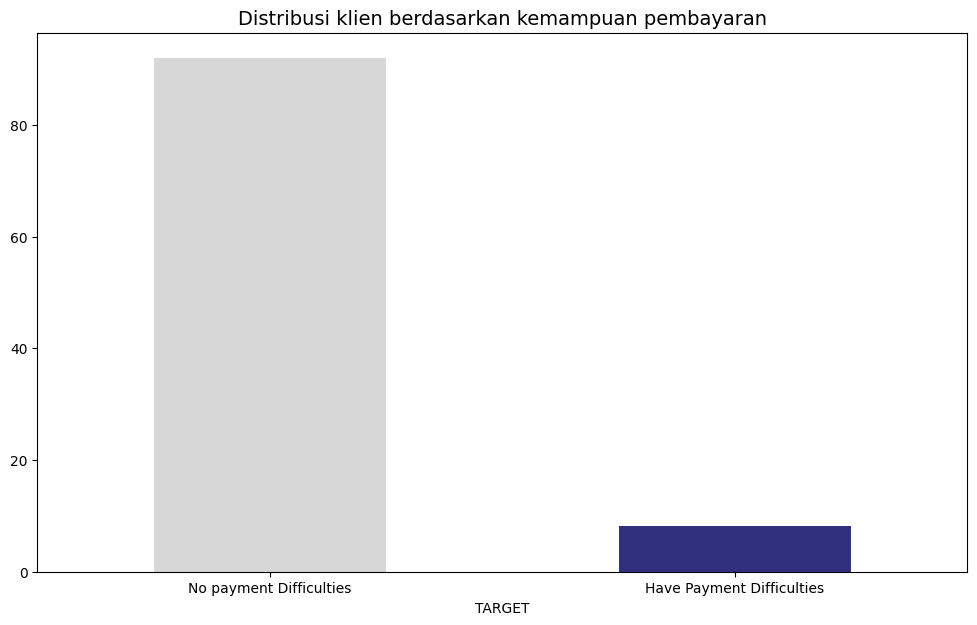

In [9]:
fig = plt.figure(figsize = (12,7))
grp.plot(kind='bar', color=['lightgray','midnightblue'], alpha = 0.9, rot=0)
plt.title('Distribusi klien berdasarkan kemampuan pembayaran', fontsize=14)
plt.show()

In [10]:
train.NAME_FAMILY_STATUS.value_counts()

,count
NAME_FAMILY_STATUS,
Married,124298
Single / not married,28542
Civil marriage,18714
Separated,12439
Widow,10133
Unknown,2


In [11]:
married=['Married','Civil marriage']
train['MARTIAL_STATUS']=np.where(train['NAME_FAMILY_STATUS'].isin(married),'Married','Unmarried')
train.drop(columns=['NAME_FAMILY_STATUS'],inplace=True)

In [12]:
train.MARTIAL_STATUS.value_counts()

,count
MARTIAL_STATUS,
Married,143012
Unmarried,51117


<Axes: title={'center': 'kemampuan pembayaran klien berdasarkan status pernikahan'}, xlabel='MARTIAL_STATUS', ylabel='count'>

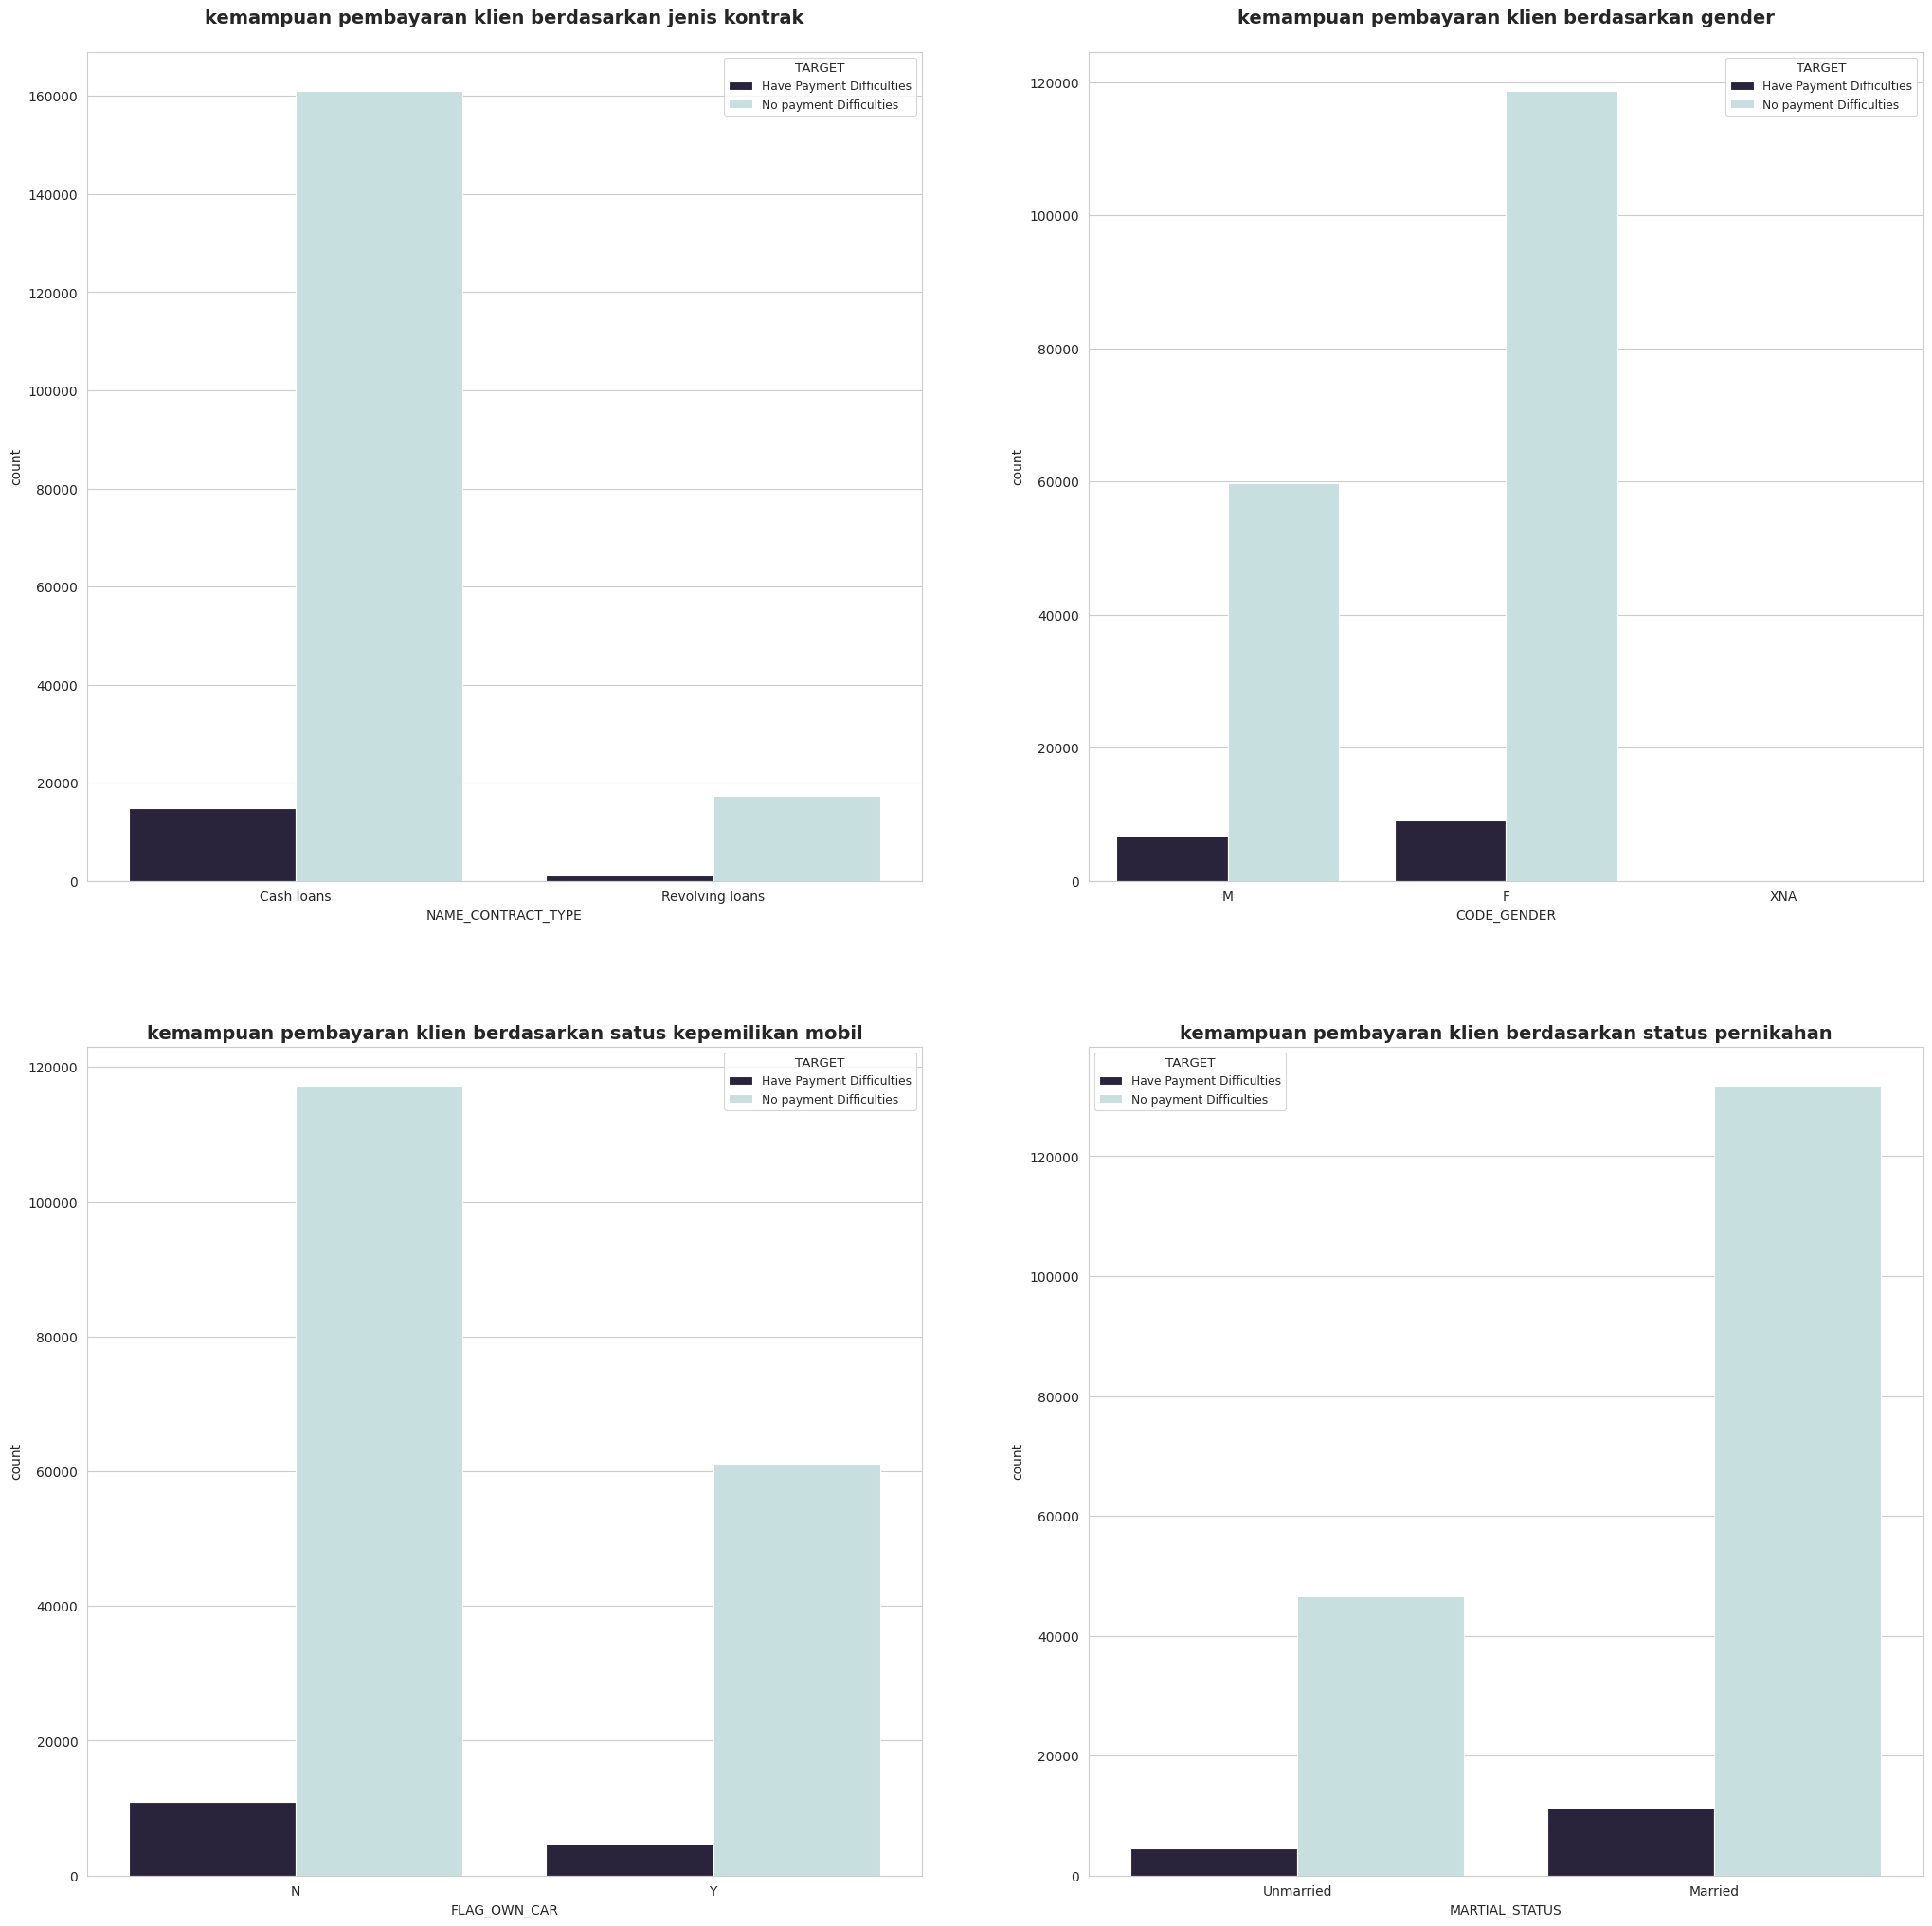

In [13]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(2,2, figsize=(25,25))
sns.set_context('paper',font_scale=1)

ax[0][0].set_title('kemampuan pembayaran klien berdasarkan jenis kontrak\n', fontweight='bold', fontsize=14 )
sns.countplot(x='NAME_CONTRACT_TYPE',data=train, hue='TARGET', palette= 'ch:start=0.2, rot=-.3_r',ax=ax[0][0])
ax[0][1].set_title('kemampuan pembayaran klien berdasarkan gender\n', fontweight='bold', fontsize=14)
sns.countplot(x='CODE_GENDER',data=train, hue='TARGET',palette= 'ch:start=0.2, rot=-.3_r',ax=ax[0][1])
ax[1][0].set_title('kemampuan pembayaran klien berdasarkan satus kepemilikan mobil',fontweight='bold', fontsize=14)
sns.countplot(x='FLAG_OWN_CAR', data=train,hue='TARGET', palette='ch:start=0.2, rot=-.3_r', ax=ax[1][0])
ax[1][1].set_title('kemampuan pembayaran klien berdasarkan status pernikahan', fontweight='bold', fontsize=14)
sns.countplot(x='MARTIAL_STATUS',data=train, hue='TARGET', palette='ch:start=0.2, rot=-.3_r',ax=ax[1][1])

Contract Type

In [14]:
ct=train.groupby(['NAME_CONTRACT_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count().sort_values(by=['SK_ID_CURR'], ascending=False)\
.assign(PERCENTAGE =lambda x: ( x ['SK_ID_CURR']/len(train)*100).round(2))
print('Kemampuan Pembayaran Klien berdasarkan Jenis Kontrak')
ct.style.background_gradient(cmap='Greens').format({'PERCENTAGE' : '{:.2f}%'})

Kemampuan Pembayaran Klien berdasarkan Jenis Kontrak


,NAME_CONTRACT_TYPE,TARGET,SK_ID_CURR,PERCENTAGE
1,Cash loans,No payment Difficulties,160959,82.91%
3,Revolving loans,No payment Difficulties,17398,8.96%
0,Cash loans,Have Payment Difficulties,14754,7.60%
2,Revolving loans,Have Payment Difficulties,1018,0.52%


In [15]:
df[['NAME_CONTRACT_TYPE','TARGET']].groupby(['NAME_CONTRACT_TYPE'],as_index=False).mean().sort_values(['TARGET'],ascending=False)

,NAME_CONTRACT_TYPE,TARGET
0,Cash loans,0.083966
1,Revolving loans,0.055278


Code Gender insight

In [16]:
train['CODE_GENDER'] = train['CODE_GENDER'].replace(['M','F'],['Male','Female'])

In [17]:
cgt = train.groupby(['CODE_GENDER','TARGET'], as_index=False)['SK_ID_CURR'].count()\
.sort_values(['SK_ID_CURR'], ascending=False)
cgt = cgt.assign(PERCENTAGE = (cgt["SK_ID_CURR"]/len(train)*100).round(2))

print('Kemampuan Pembayaran Klien Berdasarkan Jenis Kelamin')
cgt.style.background_gradient(cmap='Greens').format({'PERCENTAGE' : '{:.2f}%'})

Kemampuan Pembayaran Klien Berdasarkan Jenis Kelamin


,CODE_GENDER,TARGET,SK_ID_CURR,PERCENTAGE
1,Female,No payment Difficulties,118642,61.12%
3,Male,No payment Difficulties,59711,30.76%
0,Female,Have Payment Difficulties,9004,4.64%
2,Male,Have Payment Difficulties,6768,3.49%
4,XNA,No payment Difficulties,4,0.00%


In [18]:
df[['CODE_GENDER','TARGET']].groupby(['CODE_GENDER'], as_index=False).mean().sort_values(['TARGET'], ascending=False)

,CODE_GENDER,TARGET
1,M,0.101807
0,F,0.070539
2,XNA,0.000000


Flag_own_car

In [19]:
train['FLAG_OWN_CAR'] = train['FLAG_OWN_CAR'].replace(['Y','N'],['Yes','No'])

In [20]:
foc = train.groupby(['FLAG_OWN_CAR','TARGET'],as_index=False)['SK_ID_CURR'].count().sort_values(['SK_ID_CURR'],ascending= False)\
.assign(PERCENTAGE = lambda x:(x['SK_ID_CURR']/len(train)*100).round(2))
print('Kemampuan Pembayaran Klien Berdasarkan Kepemilikan Mobil')
foc.style\
.background_gradient(cmap='Greens')\
.format({'PERCENTAGE' : '{:.2F}%'})

Kemampuan Pembayaran Klien Berdasarkan Kepemilikan Mobil


,FLAG_OWN_CAR,TARGET,SK_ID_CURR,PERCENTAGE
1,No,No payment Difficulties,117176,60.36%
3,Yes,No payment Difficulties,61181,31.52%
0,No,Have Payment Difficulties,10982,5.66%
2,Yes,Have Payment Difficulties,4790,2.47%


In [21]:
df[['FLAG_OWN_CAR','TARGET']].groupby(['FLAG_OWN_CAR'],as_index=False).mean().sort_values(['TARGET'],ascending=False)

,FLAG_OWN_CAR,TARGET
0,N,0.085691
1,Y,0.072608


Martial Status

In [22]:
mst = train.groupby(['MARTIAL_STATUS','TARGET'],as_index=False)['SK_ID_CURR'].count()\
.sort_values(['SK_ID_CURR'],ascending=False).assign(PERCENTAGE =lambda x:(x['SK_ID_CURR']/len(train)*100).round(2))
print('Kemampuan Pembayaran Klien Berdasarkan Status Pernikahan')
mst.style\
.background_gradient(cmap='Greens')\
.format({'PERCENTAGE': '{:.2f}%'})

Kemampuan Pembayaran Klien Berdasarkan Status Pernikahan


,MARTIAL_STATUS,TARGET,SK_ID_CURR,PERCENTAGE
1,Married,No payment Difficulties,131702,67.84%
3,Unmarried,No payment Difficulties,46655,24.03%
0,Married,Have Payment Difficulties,11310,5.83%
2,Unmarried,Have Payment Difficulties,4462,2.30%


In [23]:
married=['Married','Civil marriage']
df['MARTIAL_STATUS']=np.where(df['NAME_FAMILY_STATUS'].isin(married),'Married','Unmarried')
df.drop(columns=['NAME_FAMILY_STATUS'],inplace=True)

In [24]:
df.groupby('MARTIAL_STATUS',as_index=False)['TARGET'].mean().sort_values(['TARGET'],ascending=False)

,MARTIAL_STATUS,TARGET
1,Unmarried,0.087290
0,Married,0.079084


Suite Type, Income Type, Education Type, and Family Status

<Axes: title={'center': 'Kemampuan Pmebayaran Klien Berdasarkan Tipe Rumah'}, xlabel='NAME_HOUSING_TYPE', ylabel='count'>

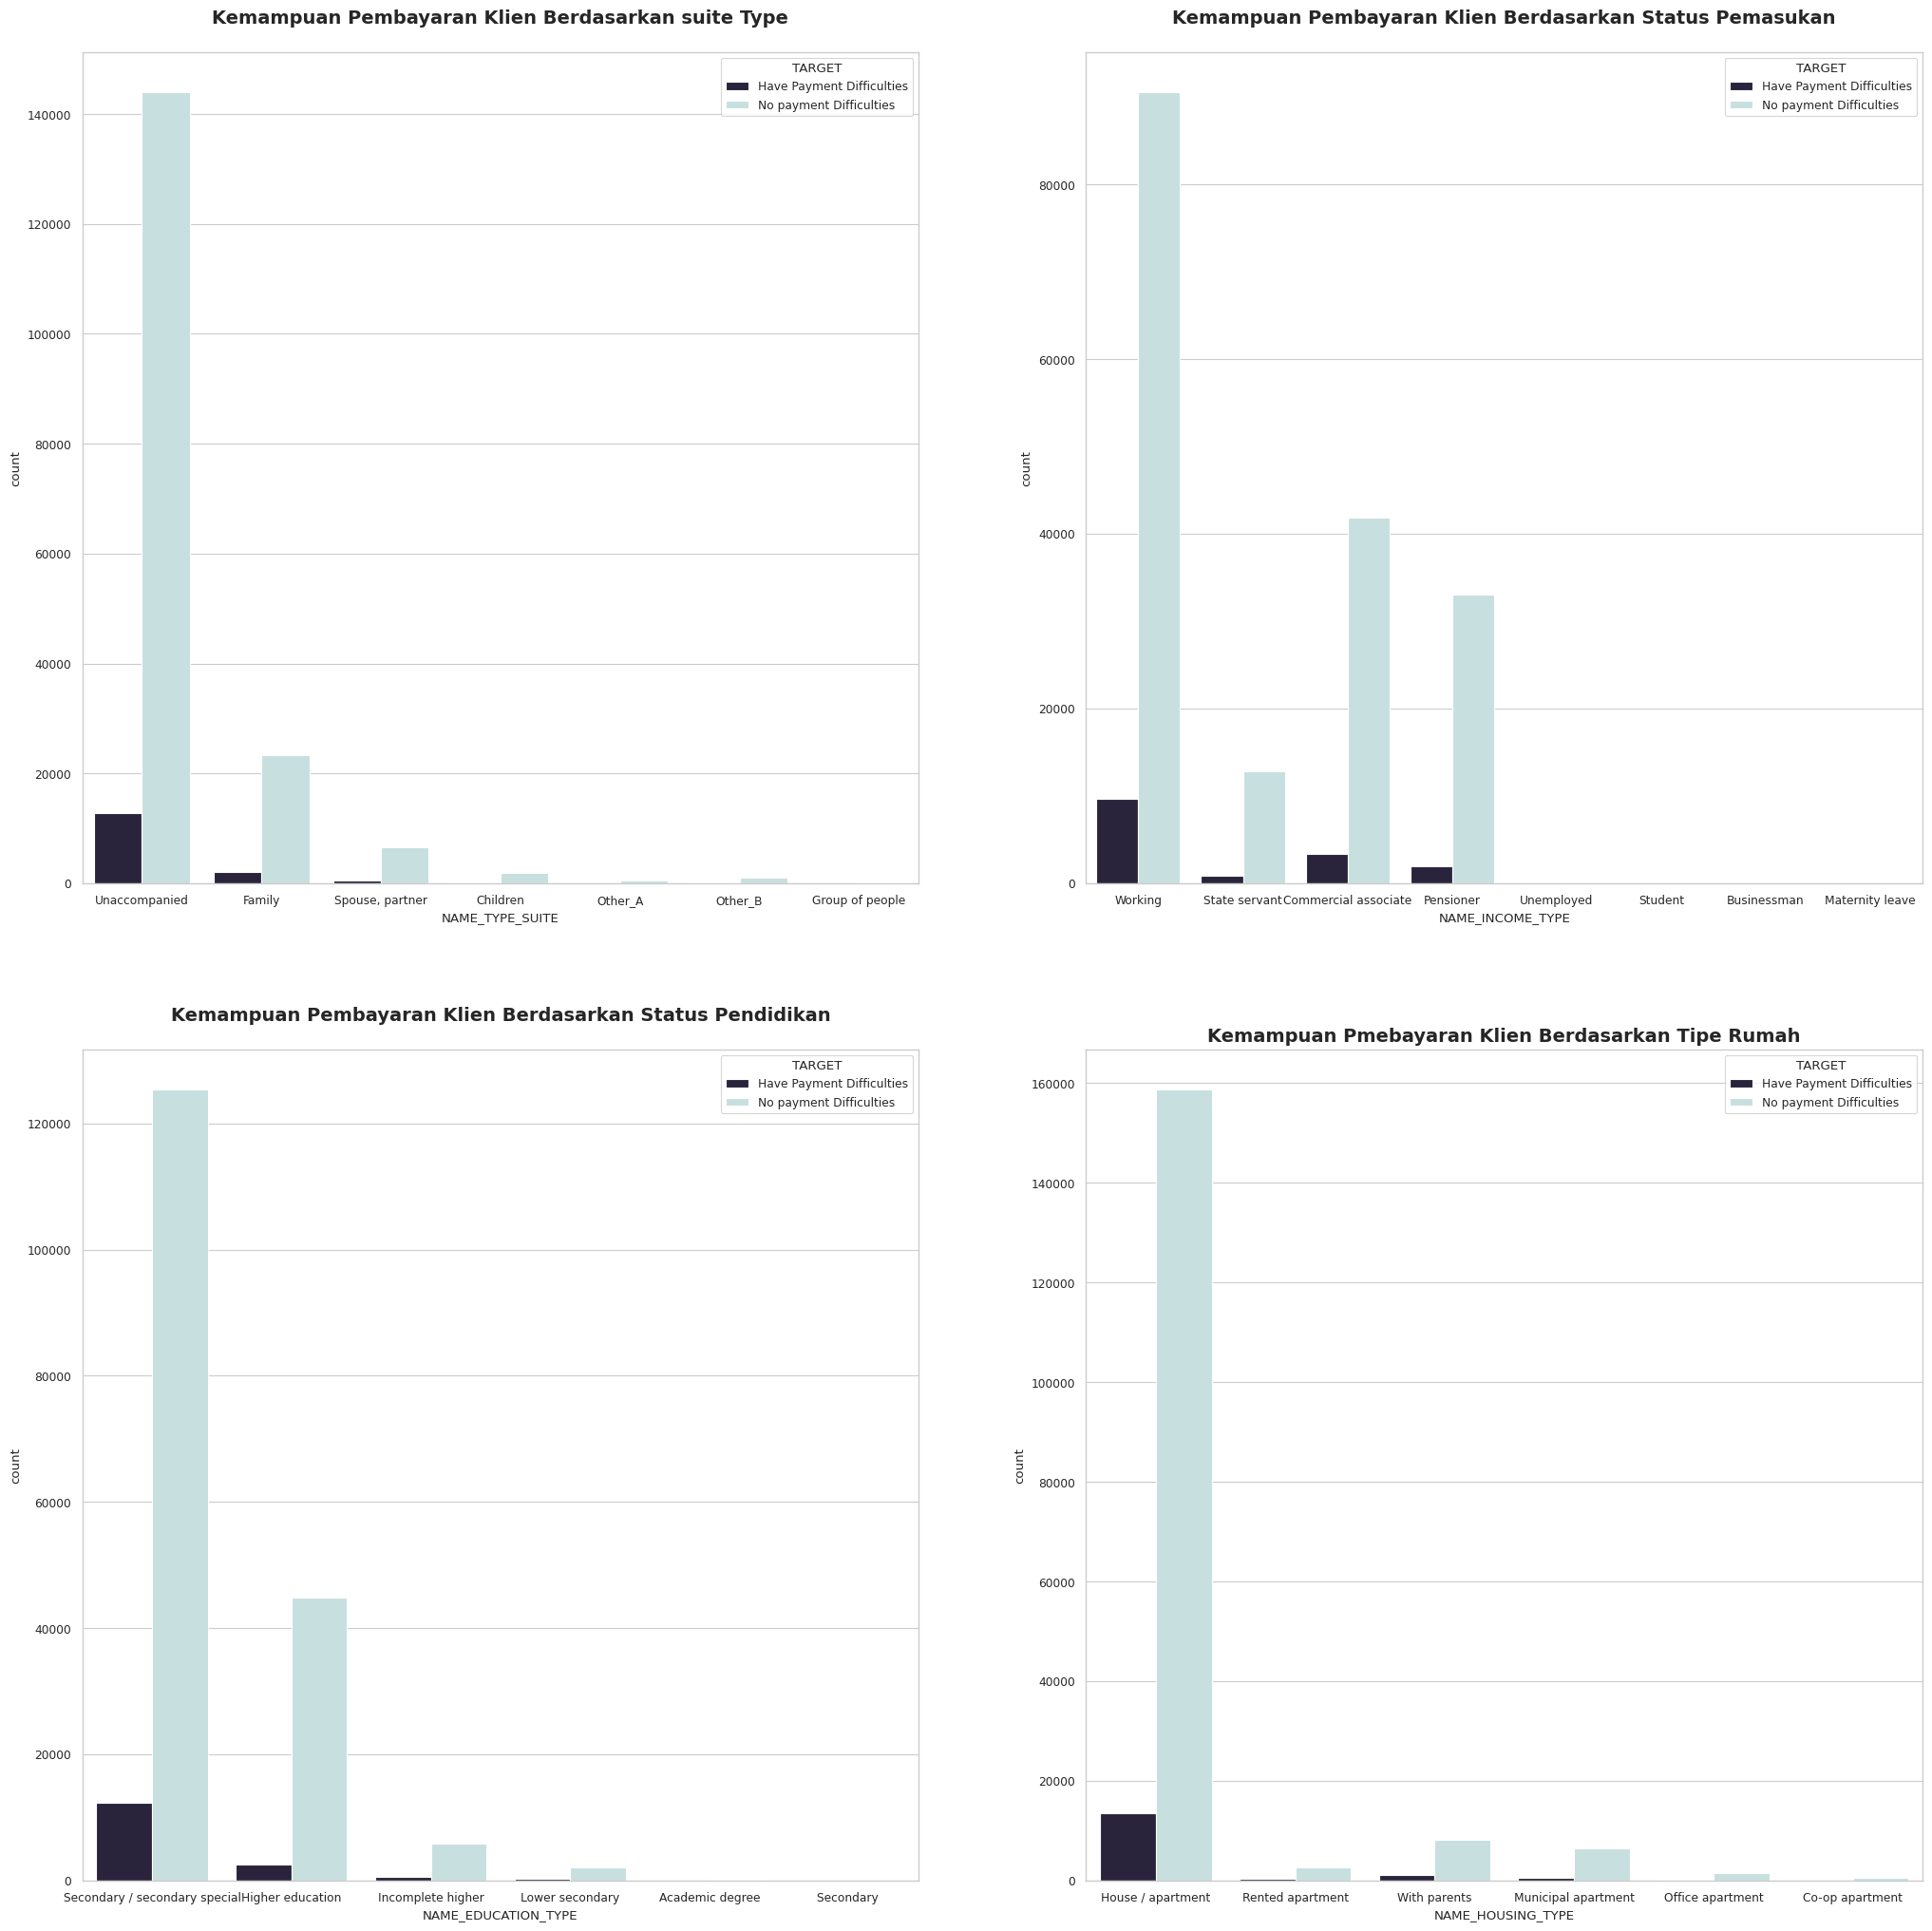

In [25]:
sns.set_style('whitegrid')
fig,ax = plt.subplots(2,2, figsize=(25,25))
sns.set_context('paper',font_scale=1)

ax[0][0].set_title('Kemampuan Pembayaran Klien Berdasarkan suite Type\n',fontweight='bold',fontsize=14)
sns.countplot(x='NAME_TYPE_SUITE',data=train,hue='TARGET',palette='ch:start=.2,rot=-.3_r',ax=ax[0][0])
ax[0][1].set_title('Kemampuan Pembayaran Klien Berdasarkan Status Pemasukan\n',fontweight='bold',fontsize=14)
sns.countplot(x='NAME_INCOME_TYPE',data=train,hue='TARGET',palette='ch:start=.2,rot=-.3_r',ax=ax[0][1])
ax[1][0].set_title('Kemampuan Pembayaran Klien Berdasarkan Status Pendidikan\n',fontweight='bold',fontsize=14)
sns.countplot(x='NAME_EDUCATION_TYPE',data=train,hue='TARGET',palette='ch:start=.2,rot=-.3_r',ax=ax[1][0])
ax[1][1].set_title('Kemampuan Pmebayaran Klien Berdasarkan Tipe Rumah',fontweight='bold',fontsize=14)
sns.countplot(x='NAME_HOUSING_TYPE',data=train,hue='TARGET',palette='ch:start=.2,rot=-.3_r',ax=ax[1][1])

Suite Type

In [26]:
st=train.groupby(['NAME_TYPE_SUITE','TARGET'],as_index=False)['SK_ID_CURR'].count().sort_values(['SK_ID_CURR'],ascending=False)\
.assign(PERCENTAGE=lambda x:(x['SK_ID_CURR']/len(train)*100).round(2))
print('Kemampuan Pembayaran Klien Berdasarkan Suite Type')
st.style\
.background_gradient(cmap='Greens')\
.format({'PERCENTAGE': '{:.2f}%'})

Kemampuan Pembayaran Klien Berdasarkan Suite Type


,NAME_TYPE_SUITE,TARGET,SK_ID_CURR,PERCENTAGE
13,Unaccompanied,No payment Difficulties,144069,74.21%
3,Family,No payment Difficulties,23372,12.04%
12,Unaccompanied,Have Payment Difficulties,12854,6.62%
11,"Spouse, partner",No payment Difficulties,6636,3.42%
2,Family,Have Payment Difficulties,1979,1.02%
1,Children,No payment Difficulties,1900,0.98%
9,Other_B,No payment Difficulties,983,0.51%
10,"Spouse, partner",Have Payment Difficulties,576,0.30%
7,Other_A,No payment Difficulties,487,0.25%
0,Children,Have Payment Difficulties,164,0.08%


In [27]:
df[['NAME_TYPE_SUITE','TARGET']].groupby(['NAME_TYPE_SUITE'],as_index=False).mean().sort_values(['TARGET'],ascending=False)

,NAME_TYPE_SUITE,TARGET
3,Other_A,0.089720
4,Other_B,0.088126
6,Unaccompanied,0.081913
5,"Spouse, partner",0.079867
0,Children,0.079457
1,Family,0.078064
2,Group of people,0.073864


income Type

In [28]:
it =train.groupby(['NAME_INCOME_TYPE','TARGET'],as_index=False)['SK_ID_CURR'].count().sort_values(['SK_ID_CURR'],ascending=False)\
.assign(PERCENTAGE=lambda x:(x['SK_ID_CURR']/len(train)*100).round(2))
print('Kemampuan Pembayaran Klien Berdasarkan Status Pemasukan')
it.style\
.background_gradient(cmap='Greens')\
.format({'PERCENTAGE': '{:.2f}%'})

Kemampuan Pembayaran Klien Berdasarkan Status Pemasukan


,NAME_INCOME_TYPE,TARGET,SK_ID_CURR,PERCENTAGE
12,Working,No payment Difficulties,90618,46.68%
2,Commercial associate,No payment Difficulties,41889,21.58%
5,Pensioner,No payment Difficulties,33021,17.01%
7,State servant,No payment Difficulties,12799,6.59%
11,Working,Have Payment Difficulties,9652,4.97%
1,Commercial associate,Have Payment Difficulties,3387,1.74%
4,Pensioner,Have Payment Difficulties,1918,0.99%
6,State servant,Have Payment Difficulties,811,0.42%
8,Student,No payment Difficulties,12,0.01%
10,Unemployed,No payment Difficulties,10,0.01%


In [29]:
df[['NAME_INCOME_TYPE','TARGET']].groupby(['NAME_INCOME_TYPE'],as_index=False).mean().sort_values(['TARGET'],ascending=False)

,NAME_INCOME_TYPE,TARGET
6,Unemployed,0.285714
7,Working,0.096260
1,Commercial associate,0.074808
4,State servant,0.059589
3,Pensioner,0.054896
0,Businessman,0.000000
2,Maternity leave,0.000000
5,Student,0.000000


Education Type

In [30]:
et=train.groupby(['NAME_EDUCATION_TYPE','TARGET'],as_index=False)['SK_ID_CURR'].count().sort_values(['SK_ID_CURR'],ascending=False)\
.assign(PERCENTAGE=lambda x:(x['SK_ID_CURR']/len(train)*100).round(2))
print('Kemampuan Pembayaran Klien Bedasarkan Status Pendidikan')
et.style\
.background_gradient(cmap='Greens')\
.format({'PERCENTAGE': '{:.2f}%'})

Kemampuan Pembayaran Klien Bedasarkan Status Pendidikan


,NAME_EDUCATION_TYPE,TARGET,SK_ID_CURR,PERCENTAGE
10,Secondary / secondary special,No payment Difficulties,125439,64.62%
3,Higher education,No payment Difficulties,44786,23.07%
9,Secondary / secondary special,Have Payment Difficulties,12397,6.39%
5,Incomplete higher,No payment Difficulties,5911,3.04%
2,Higher education,Have Payment Difficulties,2561,1.32%
7,Lower secondary,No payment Difficulties,2119,1.09%
4,Incomplete higher,Have Payment Difficulties,541,0.28%
6,Lower secondary,Have Payment Difficulties,270,0.14%
1,Academic degree,No payment Difficulties,101,0.05%
0,Academic degree,Have Payment Difficulties,3,0.00%


In [31]:
df.groupby('NAME_EDUCATION_TYPE',as_index=False)['TARGET'].mean().sort_values(['TARGET'],ascending=False)

,NAME_EDUCATION_TYPE,TARGET
3,Lower secondary,0.113018
5,Secondary / secondary special,0.089940
2,Incomplete higher,0.083850
1,Higher education,0.054090
0,Academic degree,0.028846
4,Secondary,0.000000


Housing Type

In [32]:
ht=train.groupby(['NAME_HOUSING_TYPE','TARGET'],as_index=False)['SK_ID_CURR'].count().sort_values(['SK_ID_CURR'],ascending=False)\
.assign(PERCENTAGE =lambda x:(x['SK_ID_CURR']/len(train)*100).round(2))
print('Kemampuan Pembayaran Klien Berdasarkan Jenin Tempat Tinggal')
ht.style\
.background_gradient(cmap='Greens')\
.format({'PERCENTAGE': '{:.2f}%'})

Kemampuan Pembayaran Klien Berdasarkan Jenin Tempat Tinggal


,NAME_HOUSING_TYPE,TARGET,SK_ID_CURR,PERCENTAGE
3,House / apartment,No payment Difficulties,158818,81.81%
2,House / apartment,Have Payment Difficulties,13532,6.97%
11,With parents,No payment Difficulties,8226,4.24%
5,Municipal apartment,No payment Difficulties,6457,3.33%
9,Rented apartment,No payment Difficulties,2658,1.37%
7,Office apartment,No payment Difficulties,1550,0.80%
10,With parents,Have Payment Difficulties,1086,0.56%
1,Co-op apartment,No payment Difficulties,647,0.33%
4,Municipal apartment,Have Payment Difficulties,597,0.31%
8,Rented apartment,Have Payment Difficulties,377,0.19%


In [33]:
df.groupby('NAME_HOUSING_TYPE',as_index=False)['TARGET'].mean().sort_values(['TARGET'],ascending=False)

,NAME_HOUSING_TYPE,TARGET
4,Rented apartment,0.124217
5,With parents,0.116624
0,Co-op apartment,0.088732
2,Municipal apartment,0.084633
1,House / apartment,0.078515
3,Office apartment,0.070186


Age

In [34]:
no_age = df[df['TARGET']==0]['DAYS_BIRTH'].values/-365
yes_age = df[df['TARGET']==1]['DAYS_BIRTH'].values/-365

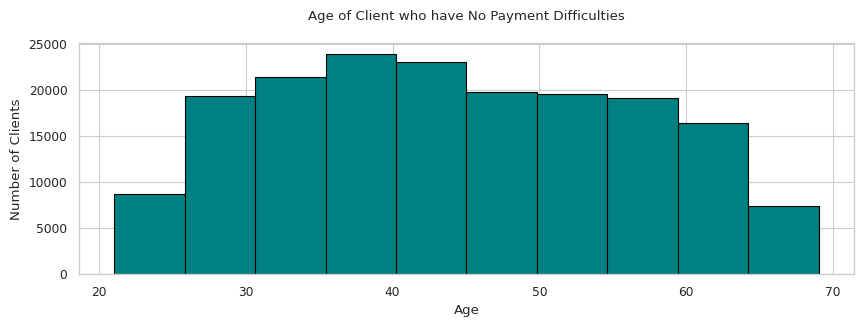

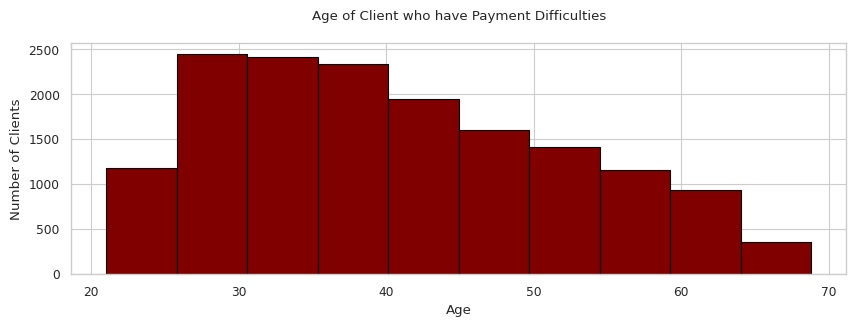

In [35]:
plt.figure(figsize=(10,3))
plt.hist(no_age, bins=10, edgecolor='black', color='teal')
plt.title('Age of Client who have No Payment Difficulties\n')
plt.xlabel('Age')
plt.ylabel('Number of Clients')
plt.show()

plt.figure(figsize=(10,3))
plt.hist(yes_age, bins=10, edgecolor='black', color='maroon')
plt.title('Age of Client who have Payment Difficulties\n')
plt.xlabel('Age')
plt.ylabel('Number of Clients')
plt.show()

## DATA CLEANING

Mendeteksi data duplikasi

In [36]:
print('The Number of Duplicationis:',df.duplicated().sum())

The Number of Duplicationis: 0


In [37]:
print('Missing Value:', df.isnull().values.any())
missing_count = df.isnull().sum()
nvc = pd.DataFrame({'TOTAL MISSING VALUE':missing_count,
                    'PERCENTAGE':(missing_count/df.shape[0])*100})
nvc = nvc[nvc['TOTAL MISSING VALUE'] > 0].sort_values('PERCENTAGE', ascending=False).reset_index()
nvc.style.format({'PERCENTAGE': '{:.2f}%'})


Missing Value: True


,index,TOTAL MISSING VALUE,PERCENTAGE
0,COMMONAREA_AVG,135727,69.92%
1,COMMONAREA_MODE,135727,69.92%
2,COMMONAREA_MEDI,135727,69.92%
3,NONLIVINGAPARTMENTS_MEDI,134802,69.44%
4,NONLIVINGAPARTMENTS_MODE,134802,69.44%
5,NONLIVINGAPARTMENTS_AVG,134802,69.44%
6,FONDKAPREMONT_MODE,132764,68.39%
7,LIVINGAPARTMENTS_AVG,132752,68.38%
8,LIVINGAPARTMENTS_MEDI,132752,68.38%
9,LIVINGAPARTMENTS_MODE,132752,68.38%


In [38]:
df.drop(columns=df.columns[df.isnull().mean() >= 0.5], inplace=True)

In [39]:
print('Missing Value:', df.isnull().values.any())
missing_count = df.isnull().sum()
nvc = pd.DataFrame({'TOTAL MISSING VALUE':missing_count,
                    'PERCENTAGE':(missing_count/df.shape[0])*100})
nvc = nvc[nvc['TOTAL MISSING VALUE'] > 0].sort_values('PERCENTAGE', ascending=False).reset_index()
nvc.style.format({'PERCENTAGE': '{:.2f}%'})


Missing Value: True


,index,TOTAL MISSING VALUE,PERCENTAGE
0,FLOORSMAX_MEDI,96674,49.80%
1,FLOORSMAX_AVG,96674,49.80%
2,FLOORSMAX_MODE,96674,49.80%
3,YEARS_BEGINEXPLUATATION_AVG,94746,48.81%
4,YEARS_BEGINEXPLUATATION_MEDI,94746,48.81%
5,YEARS_BEGINEXPLUATATION_MODE,94746,48.81%
6,TOTALAREA_MODE,93771,48.30%
7,EMERGENCYSTATE_MODE,92067,47.43%
8,OCCUPATION_TYPE,61043,31.44%
9,EXT_SOURCE_3,38521,19.84%


In [40]:
# input missing values dengan mode for feature kategori
# input missing values with median untuk kategori numeric

category_columns = df.select_dtypes(include=['object']).columns.tolist()
integer_columns = df.select_dtypes(include=['int64','float64']).columns.tolist()

for column in df:
  if df[column].isnull().any():
    if(column in category_columns):
      df[column]=df[column].fillna(df[column].mode()[0])
    else:
      df[column]=df[column].fillna(df[column].median())
print(f"Missing values in '{column}' filled with {'mode' if column in category_columns else 'median'}")

Missing values in 'MARTIAL_STATUS' filled with mode


In [41]:
print('Missing Value:', df.isnull().values.any())
missing_count = df.isnull().sum()
nvc = pd.DataFrame({'TOTAL MISSING VALUE':missing_count,
                    'PERCENTAGE':(missing_count/df.shape[0])*100})
nvc = nvc[nvc['TOTAL MISSING VALUE'] >= 0].sort_values('PERCENTAGE', ascending=False).reset_index()
nvc.style.format({'PERCENTAGE': '{:.2f}%'})

Missing Value: False


,index,TOTAL MISSING VALUE,PERCENTAGE
0,SK_ID_CURR,0,0.00%
1,TARGET,0,0.00%
2,NAME_CONTRACT_TYPE,0,0.00%
3,CODE_GENDER,0,0.00%
4,FLAG_OWN_CAR,0,0.00%
5,FLAG_OWN_REALTY,0,0.00%
6,CNT_CHILDREN,0,0.00%
7,AMT_INCOME_TOTAL,0,0.00%
8,AMT_CREDIT,0,0.00%
9,AMT_ANNUITY,0,0.00%


OUTLIER

In [42]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
numerical_columns = [col for col in numerical_columns if col not in ['SK_ID_CURR','TARGET']]
print(numerical_columns)

['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'FLOORSMAX_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'FLOORSMAX_MEDI', 'TOTALAREA_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMEN

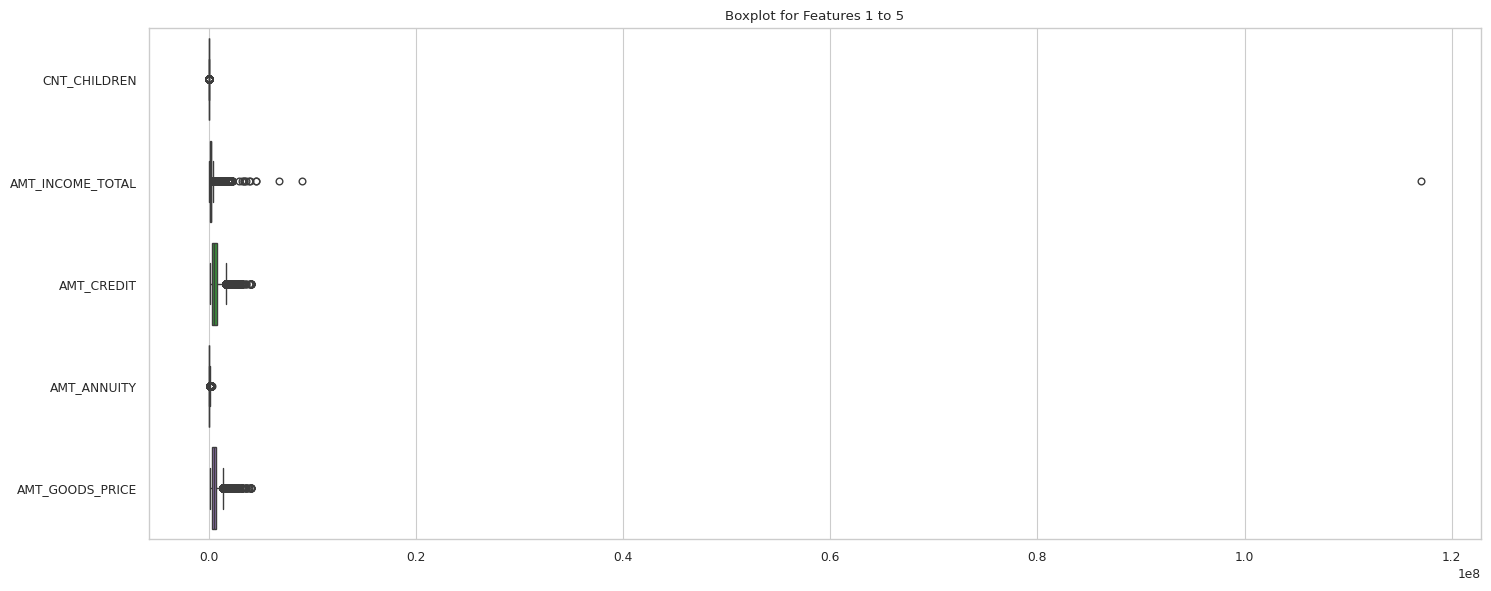

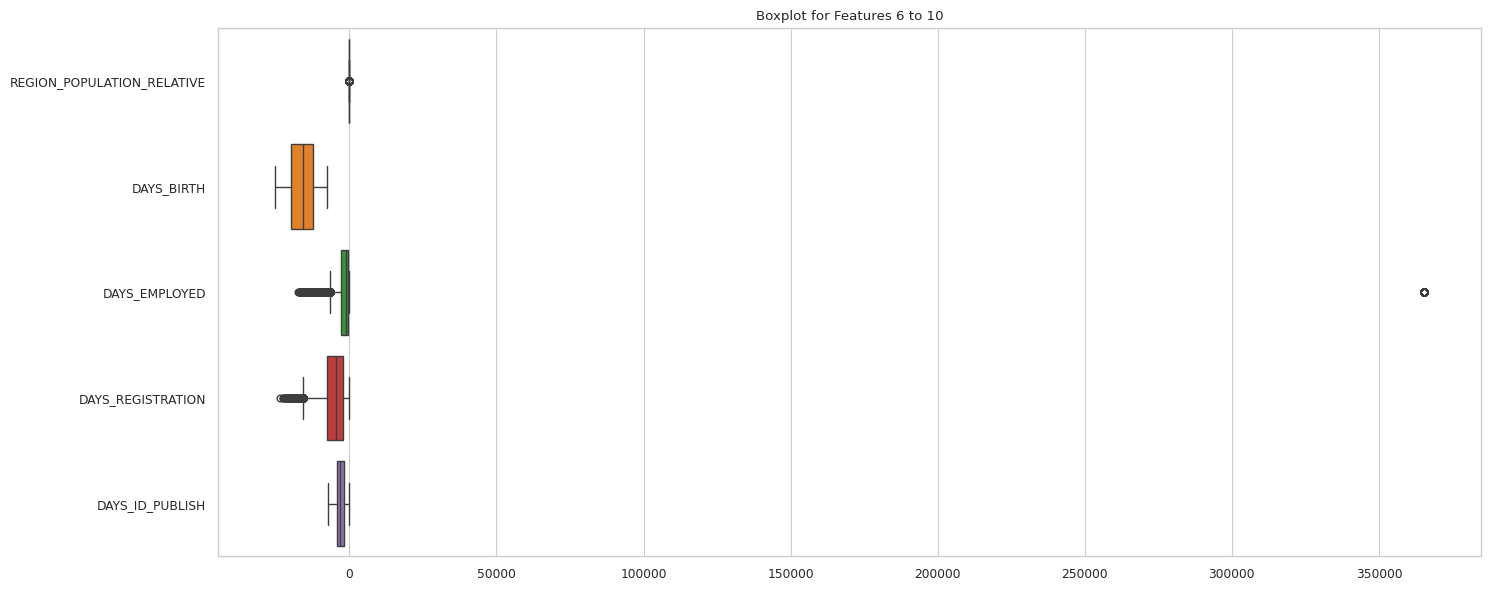

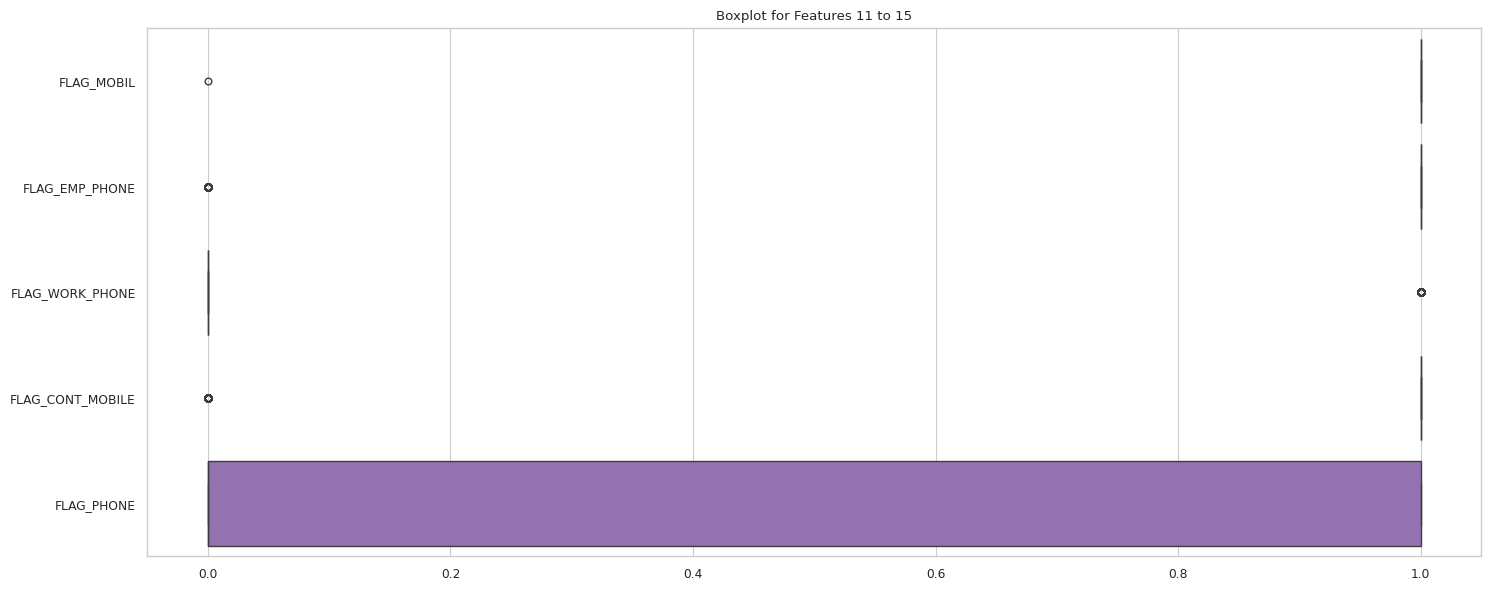

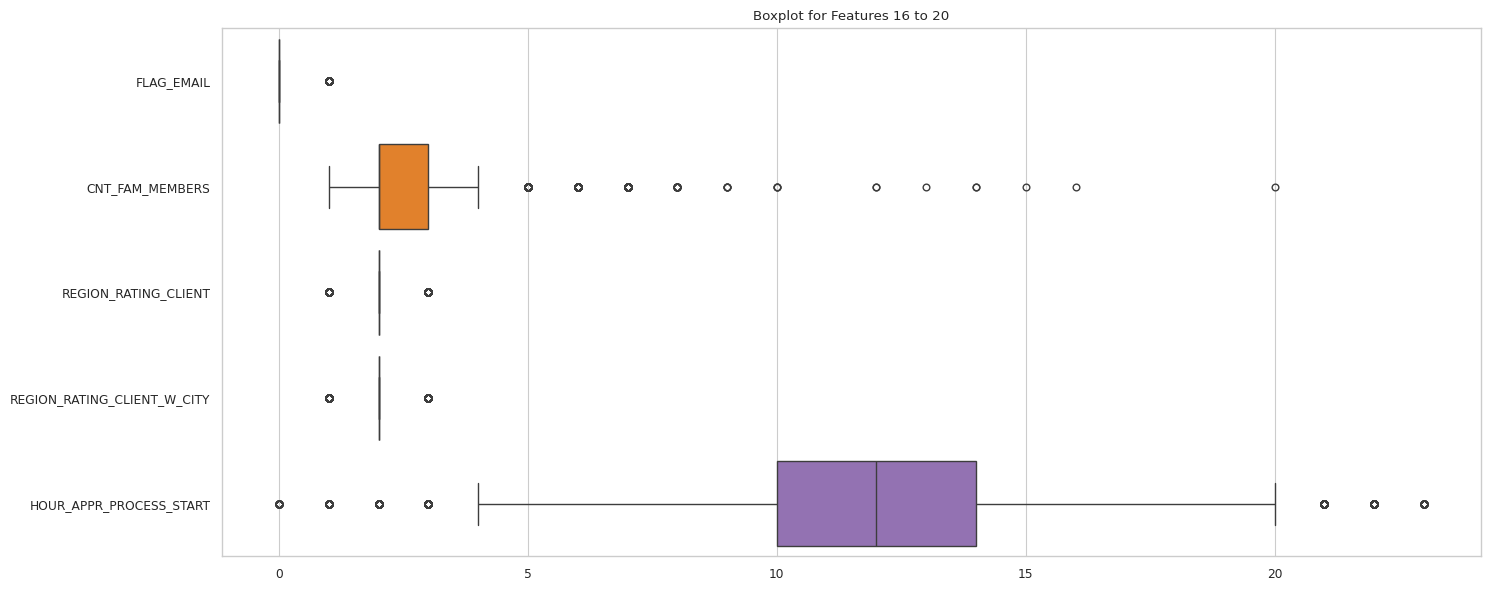

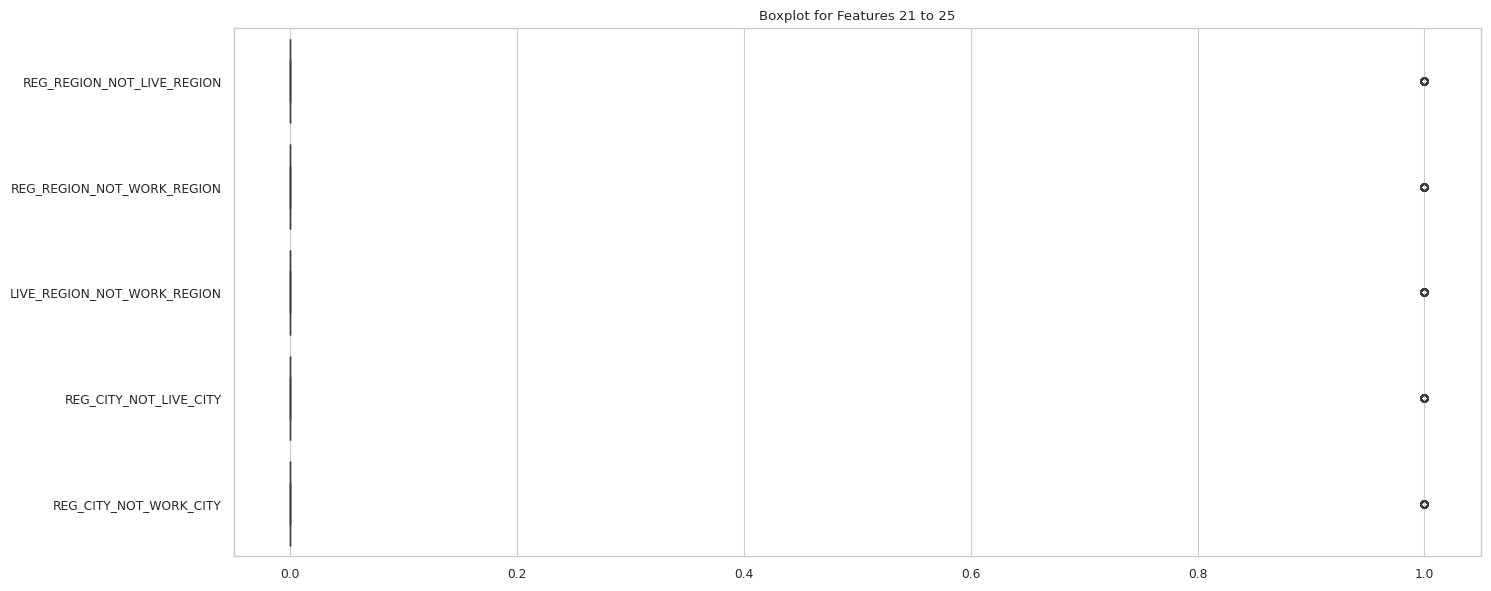

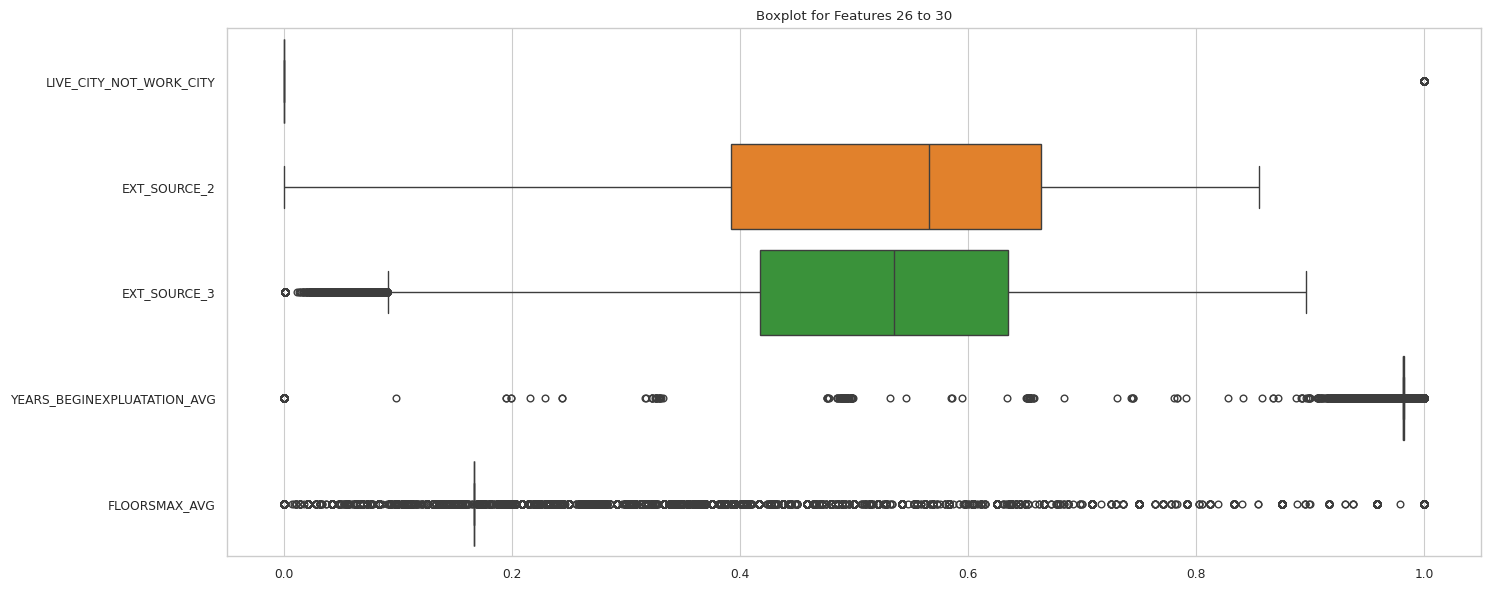

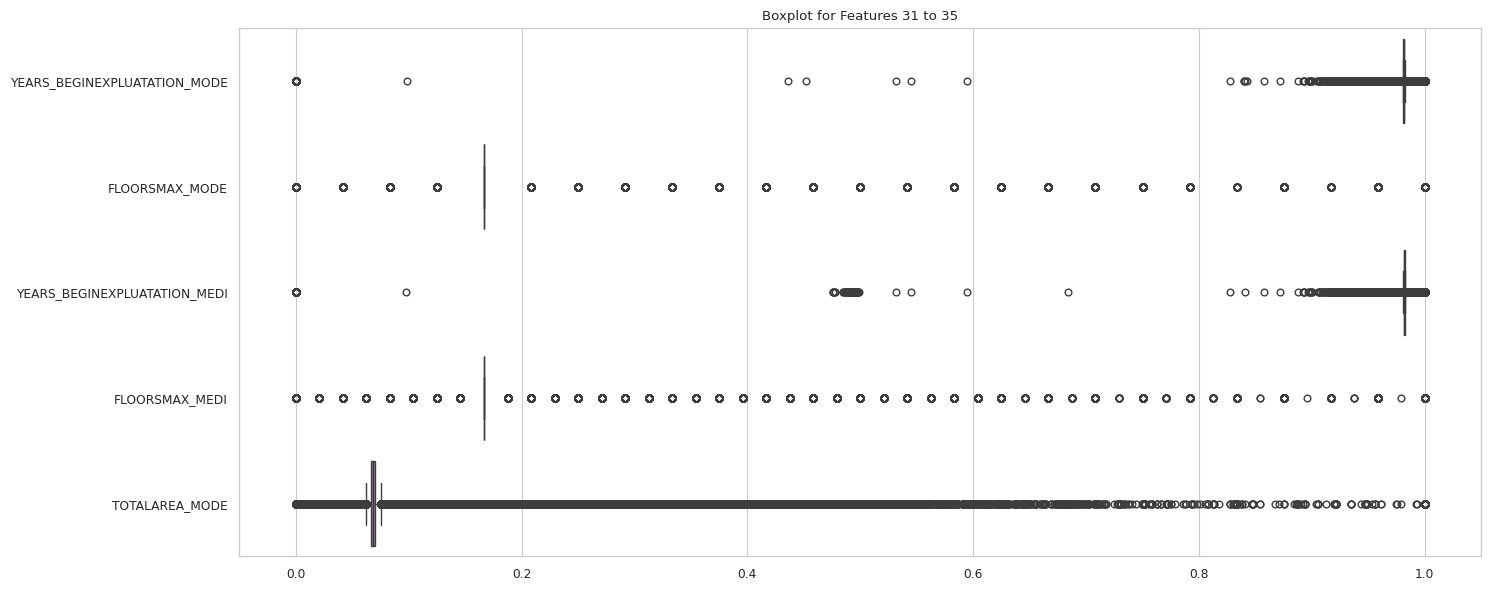

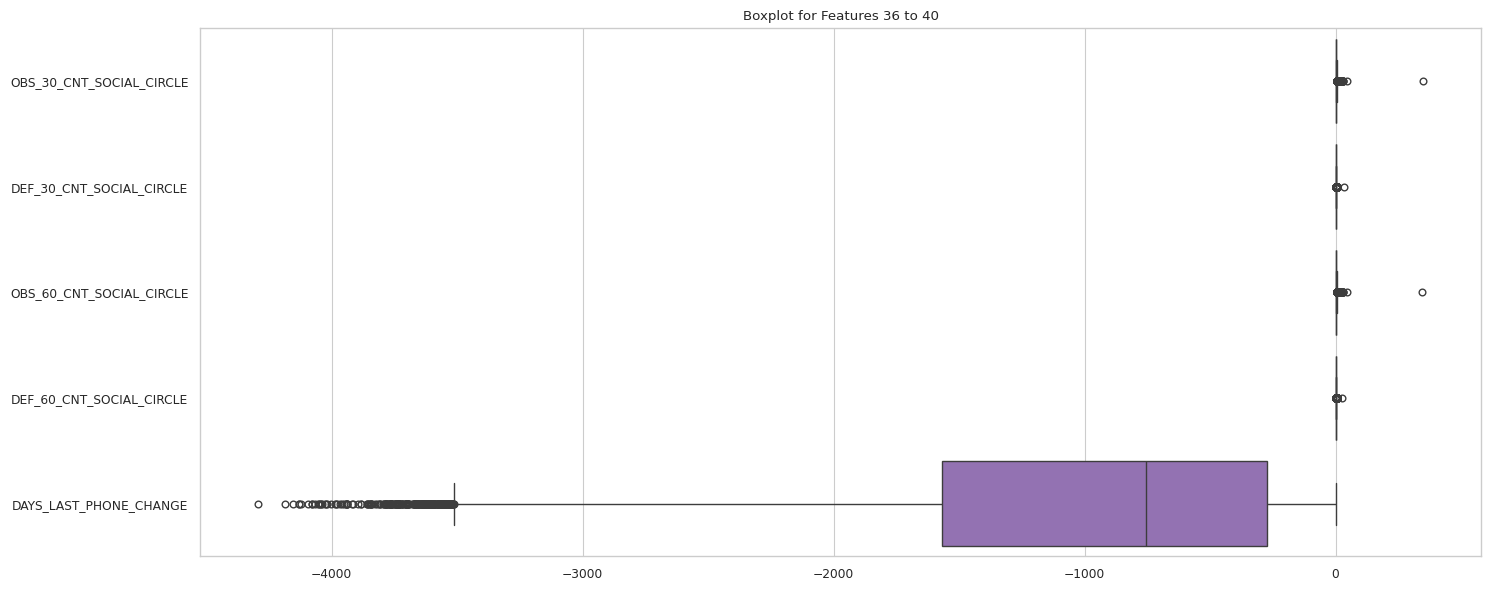

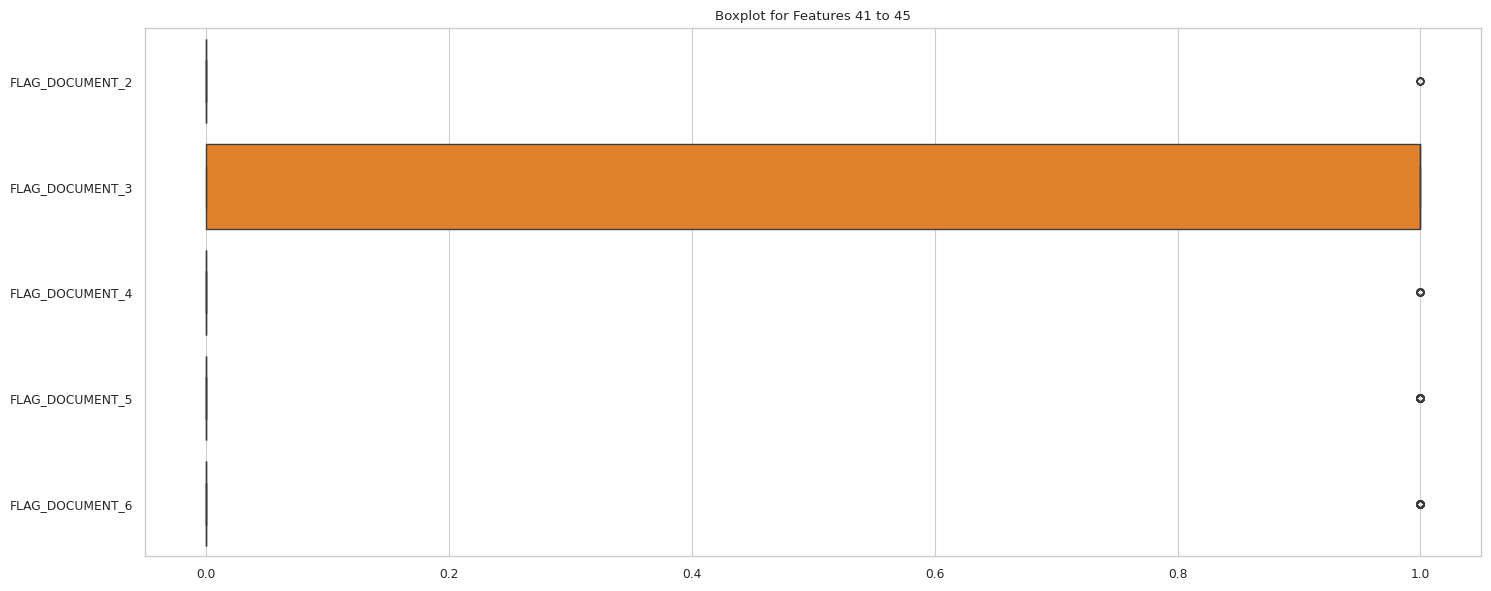

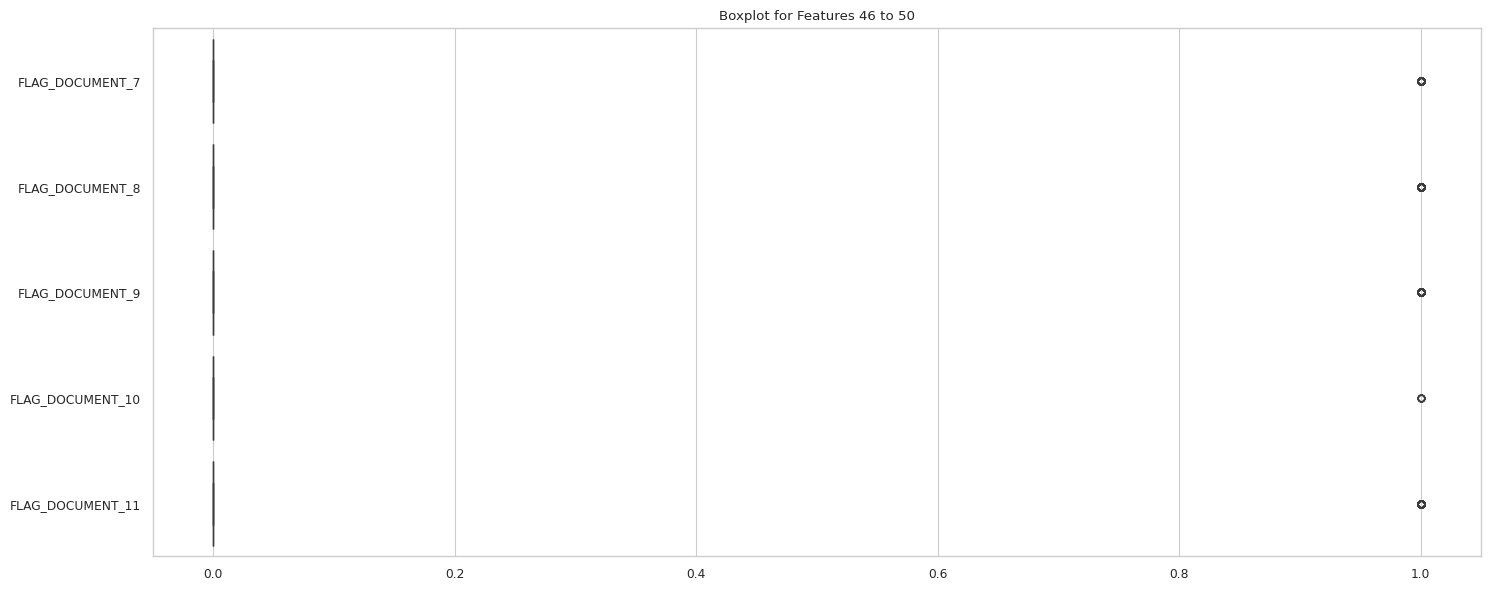

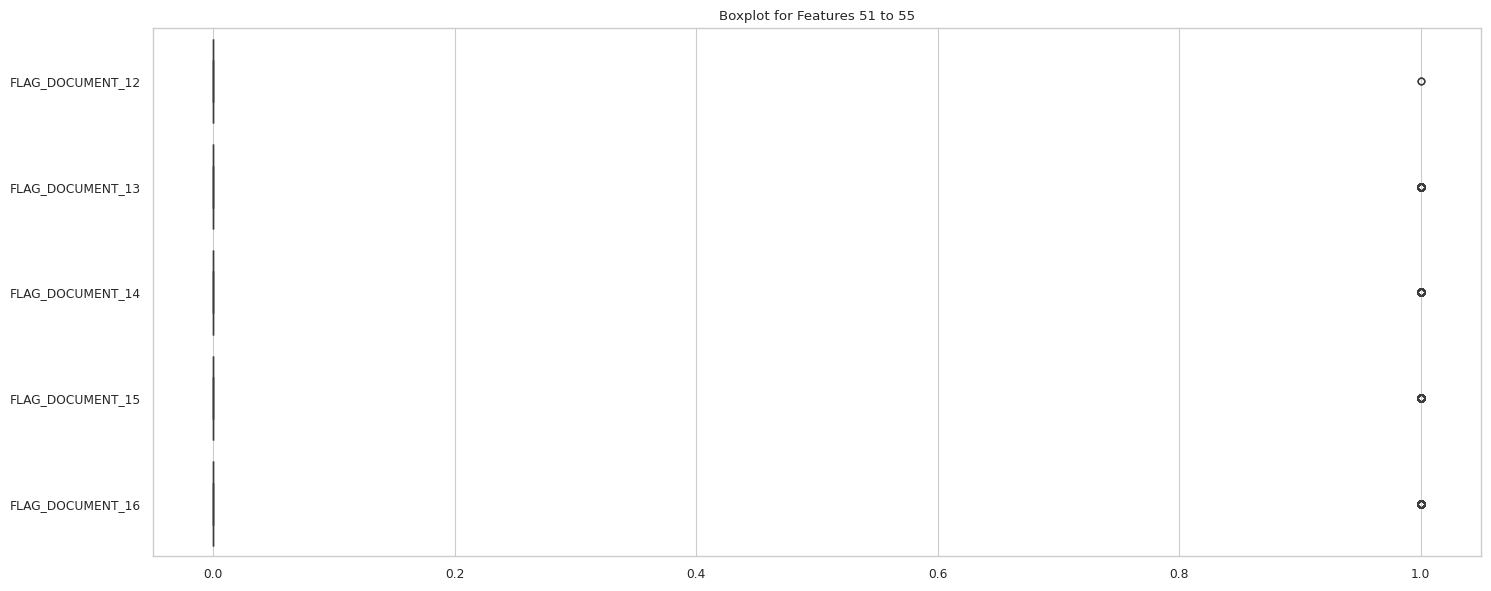

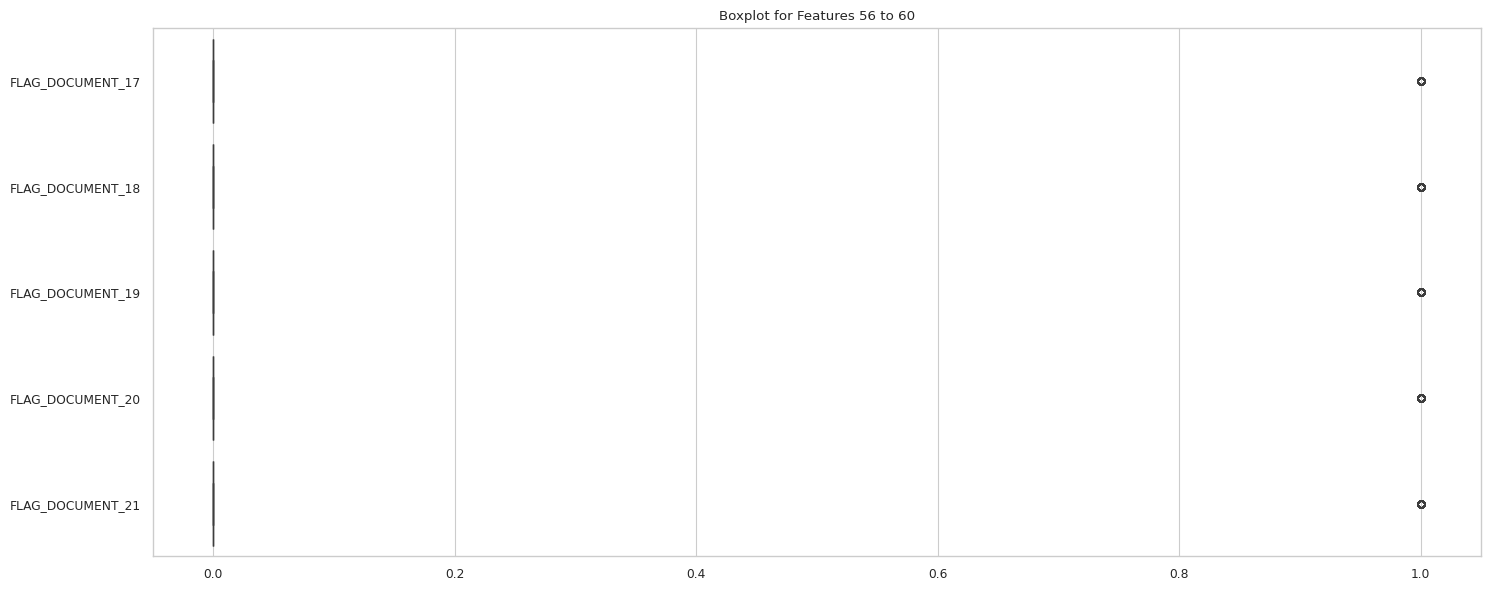

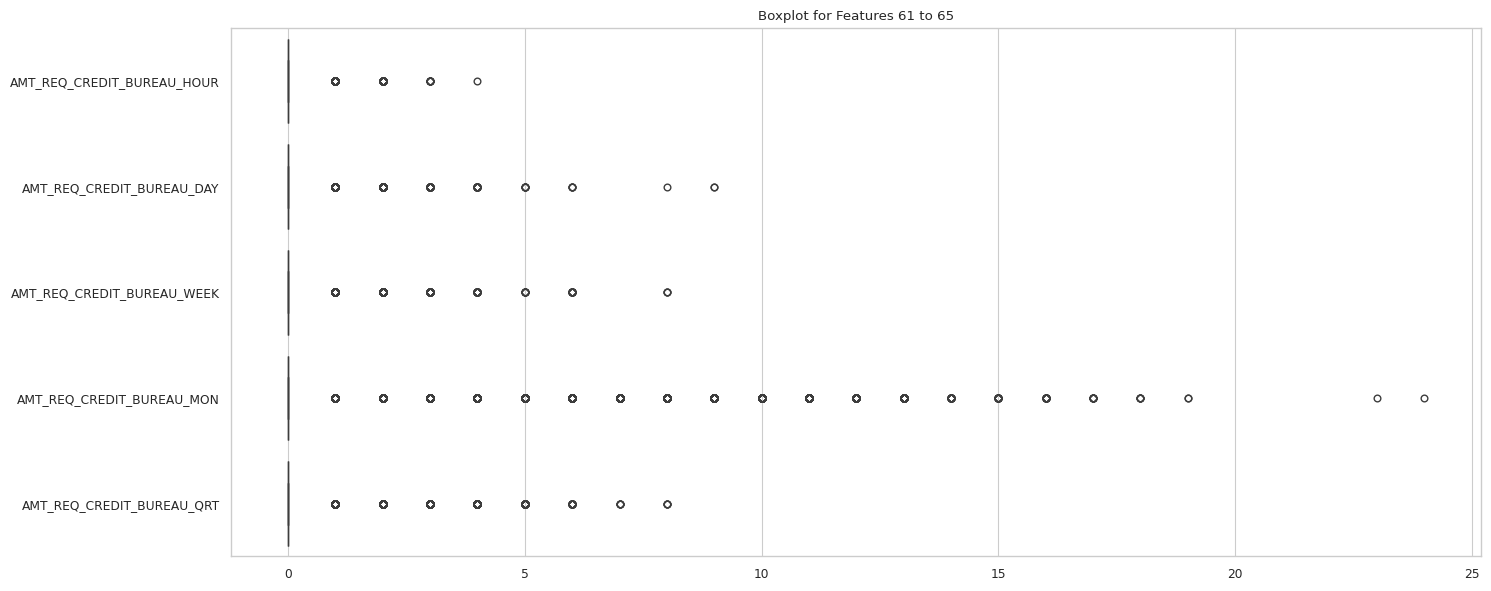

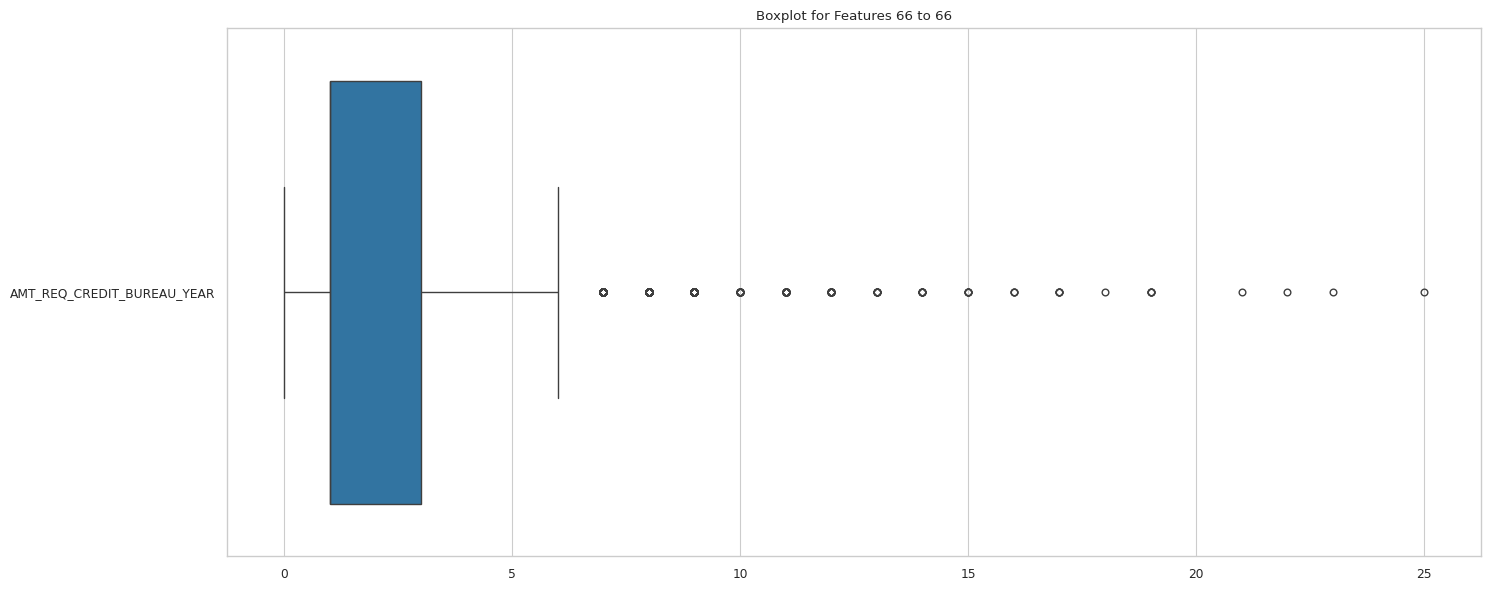

In [43]:
# Tentukan jumlah fitur per plot
n_features_per_plot = 5

# Loop melalui kolom numerik dalam kelompok berisi 5 fitur
for i in range(0, len(numerical_columns), n_features_per_plot):
    # Ambil subset kolom (max 5)
    subset_cols = numerical_columns[i:i + n_features_per_plot]

    # Buat boxplot
    plt.figure(figsize=(15, 6))
    df_subset = df[subset_cols]
    sns.boxplot(data=df_subset, orient='h')
    plt.title(f'Boxplot for Features {i+1} to {i+len(subset_cols)}')
    plt.tight_layout()
    plt.show()


## Label Encoding

In [44]:
object_columns = df.select_dtypes(include=['object']).columns
print(object_columns)

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE', 'EMERGENCYSTATE_MODE', 'MARTIAL_STATUS'],
      dtype='object')


In [45]:
from sklearn.preprocessing import LabelEncoder
for col in object_columns:
    if col in df.columns:
        # Buat objek encoder dan encode
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

In [46]:
df.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,MARTIAL_STATUS
0,100002,1,0,1,0,1,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,100003,0,0,0,0,0,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,100004,0,1,1,1,1,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,100006,0,0,0,0,1,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,100007,0,0,1,0,1,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5,100008,0,0,1,0,1,0,99000.0,490495.5,27517.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0
6,100009,0,0,0,1,1,1,171000.0,1560726.0,41301.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0
7,100010,0,0,1,1,1,0,360000.0,1530000.0,42075.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,100011,0,0,0,0,1,0,112500.0,1019610.0,33826.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
9,100012,0,1,1,0,1,0,135000.0,405000.0,20250.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1


In [47]:
df.drop(['SK_ID_CURR'],inplace=True,axis=1)

In [48]:
df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,MARTIAL_STATUS
0,1,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,0,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,0,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [49]:
#membuat kolom numerik menjadi absolut
df[numerical_columns] = df[numerical_columns].abs()

In [50]:
x=df.drop(['TARGET'],axis=1)
y=df['TARGET']

In [51]:
# feature selection
from sklearn.feature_selection import SelectKBest, chi2
bestfeatures = SelectKBest(score_func=chi2, k=20)
fit = bestfeatures.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Features', 'Score']
print('The features that correlate well with target feature:\n')
featureScores.sort_values(by=['Score'], ascending=False)

The features that correlate well with target feature:



,Features,Score
15,DAYS_EMPLOYED,1.182577e+08
8,AMT_GOODS_PRICE,7.893115e+07
6,AMT_CREDIT,5.007862e+07
14,DAYS_BIRTH,1.421549e+06
16,DAYS_REGISTRATION,7.787465e+05
...,...,...
39,YEARS_BEGINEXPLUATATION_AVG,8.181408e-03
41,YEARS_BEGINEXPLUATATION_MODE,7.646349e-03
21,FLAG_CONT_MOBILE,1.233143e-03
72,AMT_REQ_CREDIT_BUREAU_HOUR,6.640335e-04


In [52]:
# Dapatkan 20 fitur teratas
top_20_features = featureScores.sort_values(by=['Score'], ascending=False)['Features'].head(20).tolist()
print("\n20 Fitur Teratas:\n", top_20_features)

# Filter data dengan 10 fitur teratas
X_top = x[top_20_features]


20 Fitur Teratas:
 ['DAYS_EMPLOYED', 'AMT_GOODS_PRICE', 'AMT_CREDIT', 'DAYS_BIRTH', 'DAYS_REGISTRATION', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'REG_CITY_NOT_WORK_CITY', 'CODE_GENDER', 'EXT_SOURCE_2', 'REG_CITY_NOT_LIVE_CITY', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_3', 'LIVE_CITY_NOT_WORK_CITY']


## handling imbalanced data

Distribusi kelas sebelum penyeimbangan:
TARGET
0    0.918755
1    0.081245
Name: proportion, dtype: float64


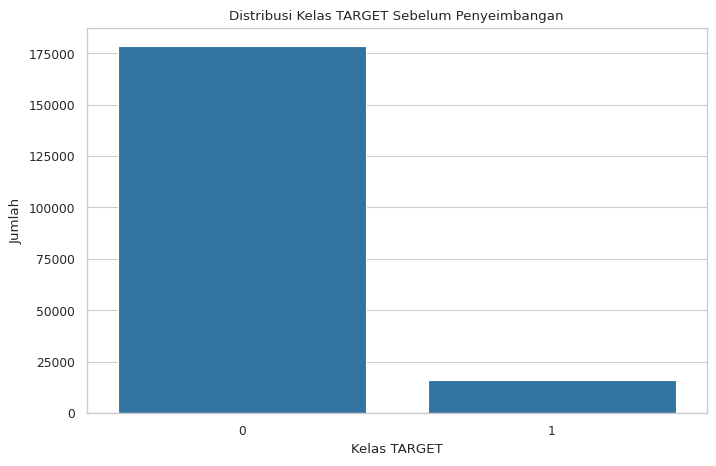

In [53]:
print("Distribusi kelas sebelum penyeimbangan:")
print(df['TARGET'].value_counts(normalize=True))

# Visualisasi distribusi kelas sebelum penyeimbangan
plt.figure(figsize=(8, 5))
sns.countplot(x='TARGET', data=df)
plt.title('Distribusi Kelas TARGET Sebelum Penyeimbangan')
plt.xlabel('Kelas TARGET')
plt.ylabel('Jumlah')
plt.show()

TARGET
1    0.5
0    0.5
Name: proportion, dtype: float64


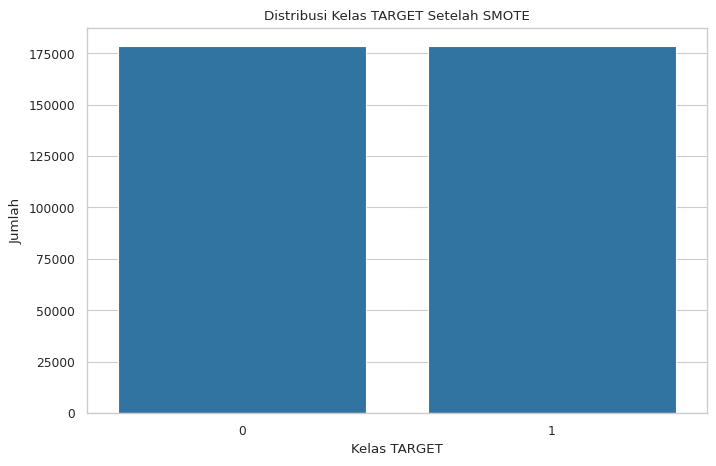

In [54]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler

# Terapkan SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_top, y)

# Konversi kembali ke DataFrame
X_smote = pd.DataFrame(X_smote, columns=X_top.columns)

# Bagi data
x_train, x_test, y_train, y_test = train_test_split(X_smote , y_smote, test_size=0.2, random_state=4)
# Periksa distribusi kelas baru
print(y_smote.value_counts(normalize=True))

# Visualisasi distribusi kelas setelah SMOTE
plt.figure(figsize=(8, 5))
sns.countplot(x=y_smote)
plt.title('Distribusi Kelas TARGET Setelah SMOTE')
plt.xlabel('Kelas TARGET')
plt.ylabel('Jumlah')
plt.show()

In [55]:
# Normalisasi data untuk model yang sensitif terhadap skala
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Modeling

1.Random Forest

In [56]:
RF=RandomForestClassifier(random_state=42)
RF.fit(x_train,y_train)

y_train_pred_RF=RF.predict(x_train)

print('Classificatian Report Random Forest:\n')
print(classification_report(y_train, y_train_pred_RF))

Classificatian Report Random Forest:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    142854
           1       1.00      1.00      1.00    142517

    accuracy                           1.00    285371
   macro avg       1.00      1.00      1.00    285371
weighted avg       1.00      1.00      1.00    285371



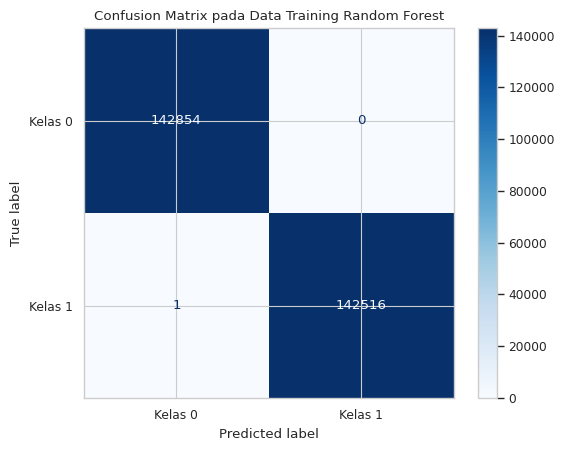

In [57]:
cm_RF = confusion_matrix(y_train, y_train_pred_RF)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_RF, display_labels=['Kelas 0', 'Kelas 1'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix pada Data Training Random Forest')
plt.show()

In [58]:
y_test_pred_proba_RF = RF.predict_proba(x_test)[:, 1]
y_test_pred_RF=RF.predict(x_test)

print('Classificatian Report Random Forest:\n')
print(classification_report(y_test, y_test_pred_RF))

Classificatian Report Random Forest:

              precision    recall  f1-score   support

           0       0.90      0.97      0.93     35503
           1       0.96      0.89      0.92     35840

    accuracy                           0.93     71343
   macro avg       0.93      0.93      0.93     71343
weighted avg       0.93      0.93      0.93     71343



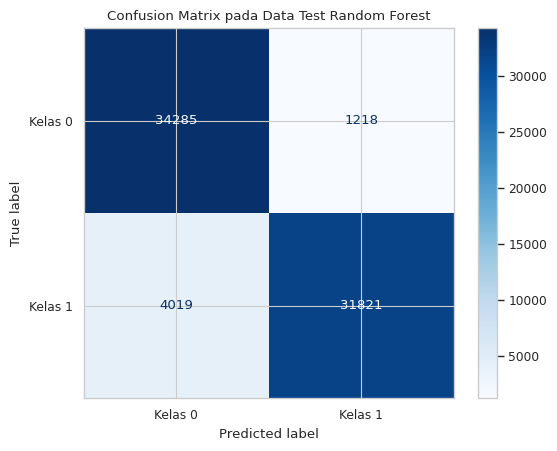

In [59]:
cm_RF = confusion_matrix(y_test, y_test_pred_RF)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_RF, display_labels=['Kelas 0', 'Kelas 1'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix pada Data Test Random Forest')
plt.show()

In [60]:
acc_RF_train=round(RF.score(x_train,y_train)*100,2)
acc_RF_test=round(RF.score(x_test,y_test)*100,2)
error_RF = round(acc_RF_test - acc_RF_train,2)
print("Training Accuracy: {} %".format(acc_RF_train))
print("Testing Accuracy: {} %".format(acc_RF_test))
print("Error: {} %".format(abs(error_RF)))

Training Accuracy: 100.0 %
Testing Accuracy: 92.66 %
Error: 7.34 %


In [61]:
# ROC scores
roc_auc_RF = round(roc_auc_score(y_test, y_test_pred_proba_RF),4)
print('ROC AUC:', roc_auc_RF)

ROC AUC: 0.9744


XG Boost

In [62]:
XGB=XGBClassifier(random_state=42,scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]))
XGB.fit(x_train,y_train)

y_train_pred_XGB=XGB.predict(x_train)

print('Classificatian Report Data Train XG Boost:\n')
print(classification_report(y_train, y_train_pred_XGB))

Classificatian Report Data Train XG Boost:

              precision    recall  f1-score   support

           0       0.88      0.96      0.92    142854
           1       0.95      0.86      0.91    142517

    accuracy                           0.91    285371
   macro avg       0.92      0.91      0.91    285371
weighted avg       0.92      0.91      0.91    285371



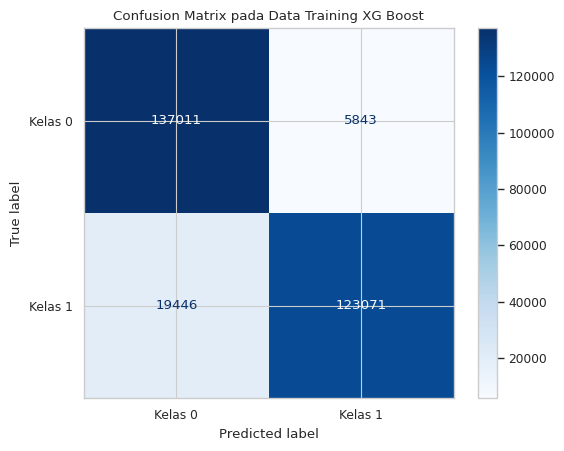

In [63]:
cm_XGB = confusion_matrix(y_train, y_train_pred_XGB)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_XGB, display_labels=['Kelas 0', 'Kelas 1'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix pada Data Training XG Boost')
plt.show()

In [64]:
y_test_pred_proba_XGB = XGB.predict_proba(x_test)[:, 1]
y_test_pred_XGB=XGB.predict(x_test)

print('Classificatian Report XG Boost:\n')
print(classification_report(y_test, y_test_pred_XGB))

Classificatian Report XG Boost:

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     35503
           1       0.95      0.85      0.90     35840

    accuracy                           0.90     71343
   macro avg       0.91      0.90      0.90     71343
weighted avg       0.91      0.90      0.90     71343



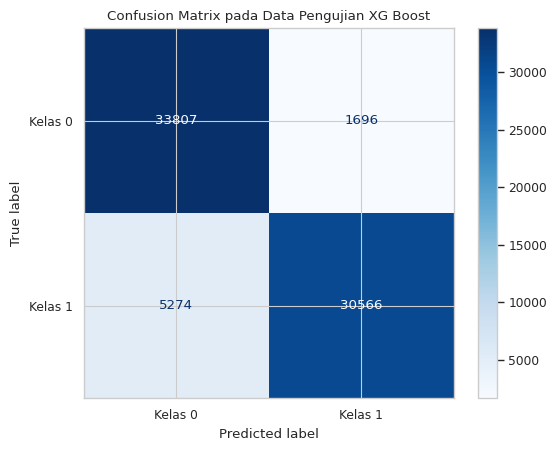

In [65]:
cm_XGB = confusion_matrix(y_test, y_test_pred_XGB)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_XGB, display_labels=['Kelas 0', 'Kelas 1'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix pada Data Pengujian XG Boost')
plt.show()

In [66]:
acc_XGB_train=round(XGB.score(x_train,y_train)*100,2)
acc_XGB_test=round(XGB.score(x_test,y_test)*100,2)
error_XGB = round(acc_XGB_test - acc_XGB_train,2)
print("Training Accuracy: {} %".format(acc_XGB_train))
print("Testing Accuracy: {} %".format(acc_XGB_test))
print("Error: {} %".format(abs(error_XGB)))

Training Accuracy: 91.14 %
Testing Accuracy: 90.23 %
Error: 0.91 %


In [67]:
# ROC scores
roc_auc_XGB = round(roc_auc_score(y_test, y_test_pred_proba_XGB),4)
print('ROC AUC:', roc_auc_XGB)

ROC AUC: 0.9584


In [68]:
LGB=LGBMClassifier(random_state=42,scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]))
LGB.fit(x_train,y_train)

y_train_pred_LGB=LGB.predict(x_train)

print('Classificatian Report LightGBM:\n')
print(classification_report(y_train, y_train_pred_LGB))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 142517, number of negative: 142854
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4119
[LightGBM] [Info] Number of data points in the train set: 285371, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499410 -> initscore=-0.002362
[LightGBM] [Info] Start training from score -0.002362


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Classificatian Report LightGBM:

              precision    recall  f1-score   support

           0       0.85      0.96      0.90    142854
           1       0.95      0.83      0.89    142517

    accuracy                           0.90    285371
   macro avg       0.90      0.90      0.90    285371
weighted avg       0.90      0.90      0.90    285371



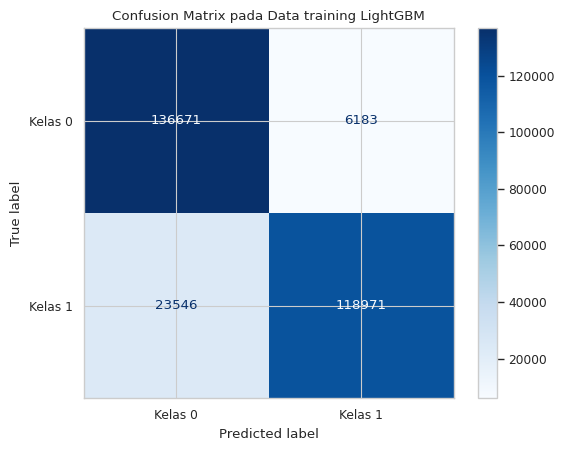

In [69]:
cm_LGB = confusion_matrix(y_train, y_train_pred_LGB)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_LGB, display_labels=['Kelas 0', 'Kelas 1'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix pada Data training LightGBM')
plt.show()

LightGBM

In [70]:
y_test_pred_proba_LGB = LGB.predict_proba(x_test)[:, 1]
y_test_pred_LGB=LGB.predict(x_test)

print('Classificatian Report LightGBM:\n')
print(classification_report(y_test, y_test_pred_LGB))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Classificatian Report LightGBM:

              precision    recall  f1-score   support

           0       0.85      0.96      0.90     35503
           1       0.95      0.83      0.89     35840

    accuracy                           0.89     71343
   macro avg       0.90      0.89      0.89     71343
weighted avg       0.90      0.89      0.89     71343



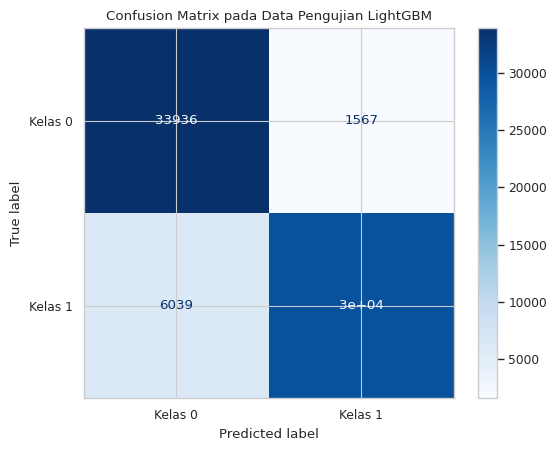

In [71]:
cm_LGB = confusion_matrix(y_test, y_test_pred_LGB)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_LGB, display_labels=['Kelas 0', 'Kelas 1'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix pada Data Pengujian LightGBM')
plt.show()

In [72]:
acc_LGB_train=round(LGB.score(x_train,y_train)*100,2)
acc_LGB_test=round(LGB.score(x_test,y_test)*100,2)
error_LGB = round(acc_LGB_test - acc_LGB_train,2)
print("Training Accuracy: {} %".format(acc_LGB_train))
print("Testing Accuracy: {} %".format(acc_LGB_test))
print("Error: {} %".format(abs(error_LGB)))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training Accuracy: 89.58 %
Testing Accuracy: 89.34 %
Error: 0.24 %


In [73]:
# ROC scores
roc_auc_LGB = round(roc_auc_score(y_test, y_test_pred_proba_LGB),4)
print('ROC AUC:', roc_auc_LGB)

ROC AUC: 0.9525


CAT BOOST

In [74]:
CB = CatBoostClassifier(
    iterations=1000,           # Maksimum jumlah pohon
    learning_rate=0.05,        # Kecepatan belajar rendah untuk stabilitas
    depth=6,                   # Kedalaman pohon sedang untuk mencegah overfitting
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  # Tangani ketidakseimbangan
    random_state=42,
    verbose=100,               # Cetak progres setiap 100 iterasi
    eval_metric='AUC',         # Optimalkan untuk ROC AUC
    early_stopping_rounds=50   # Hentikan jika tidak ada peningkatan setelah 50 iterasi
)
CB.fit(x_train,y_train)

y_train_pred_CB=CB.predict(x_train)

print('Classificatian Report CatBoost:\n')
print(classification_report(y_train, y_train_pred_CB))

0:	total: 115ms	remaining: 1m 55s
100:	total: 6.2s	remaining: 55.2s
200:	total: 17.5s	remaining: 1m 9s
300:	total: 32.6s	remaining: 1m 15s
400:	total: 40.7s	remaining: 1m
500:	total: 46.8s	remaining: 46.6s
600:	total: 54.2s	remaining: 36s
700:	total: 1m	remaining: 25.9s
800:	total: 1m 7s	remaining: 16.8s
900:	total: 1m 14s	remaining: 8.24s
999:	total: 1m 20s	remaining: 0us
Classificatian Report CatBoost:

              precision    recall  f1-score   support

           0       0.87      0.97      0.92    142854
           1       0.96      0.86      0.91    142517

    accuracy                           0.91    285371
   macro avg       0.92      0.91      0.91    285371
weighted avg       0.92      0.91      0.91    285371



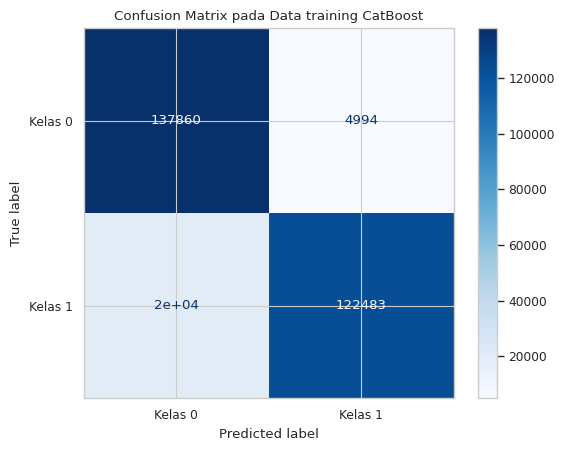

In [75]:
cm_CB = confusion_matrix(y_train, y_train_pred_CB)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_CB, display_labels=['Kelas 0', 'Kelas 1'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix pada Data training CatBoost')
plt.show()

In [76]:
y_test_pred_proba_CB = CB.predict_proba(x_test)[:, 1]
y_test_pred_CB=CB.predict(x_test)

print('Classificatian Report CatBoost:\n')
print(classification_report(y_test, y_test_pred_CB))

Classificatian Report CatBoost:

              precision    recall  f1-score   support

           0       0.87      0.96      0.91     35503
           1       0.96      0.85      0.90     35840

    accuracy                           0.91     71343
   macro avg       0.91      0.91      0.91     71343
weighted avg       0.91      0.91      0.91     71343



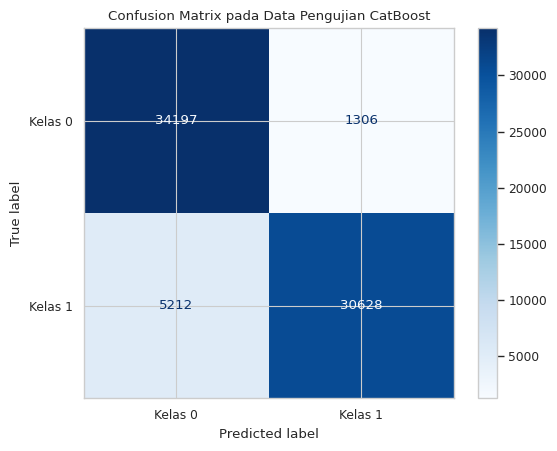

In [77]:
cm_CB = confusion_matrix(y_test, y_test_pred_CB)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_CB, display_labels=['Kelas 0', 'Kelas 1'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix pada Data Pengujian CatBoost')
plt.show()

In [78]:
acc_CB_train=round(CB.score(x_train,y_train)*100,2)
acc_CB_test=round(CB.score(x_test,y_test)*100,2)
error_CB = round(acc_CB_test - acc_CB_train,2)
print("Training Accuracy: {} %".format(acc_CB_train))
print("Testing Accuracy: {} %".format(acc_CB_test))
print("Error: {} %".format(abs(error_CB)))

Training Accuracy: 91.23 %
Testing Accuracy: 90.86 %
Error: 0.37 %


In [79]:
# ROC scores
roc_auc_CB = round(roc_auc_score(y_test, y_test_pred_proba_CB),4)
print('ROC AUC:', roc_auc_CB)

ROC AUC: 0.96


LOGISTIC REGRESSION

In [80]:
LR=LogisticRegression(class_weight='balanced',random_state=42)
LR.fit(x_train,y_train)

y_train_pred_LR=LR.predict(x_train)

print('Classificatian Report training Logistic Regression:\n')
print(classification_report(y_train, y_train_pred_LR))

Classificatian Report training Logistic Regression:

              precision    recall  f1-score   support

           0       0.69      0.69      0.69    142854
           1       0.69      0.69      0.69    142517

    accuracy                           0.69    285371
   macro avg       0.69      0.69      0.69    285371
weighted avg       0.69      0.69      0.69    285371



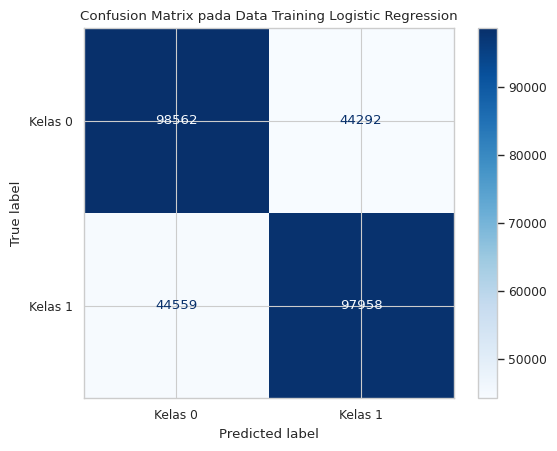

In [81]:
cm_LR = confusion_matrix(y_train, y_train_pred_LR)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_LR, display_labels=['Kelas 0', 'Kelas 1'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix pada Data Training Logistic Regression')
plt.show()

In [82]:
y_test_pred_proba_LR = LR.predict_proba(x_test)[:, 1]
y_test_pred_LR=LR.predict(x_test)

print('Classificatian Report Logistic Regression:\n')
print(classification_report(y_test, y_test_pred_LR))

Classificatian Report Logistic Regression:

              precision    recall  f1-score   support

           0       0.69      0.69      0.69     35503
           1       0.69      0.69      0.69     35840

    accuracy                           0.69     71343
   macro avg       0.69      0.69      0.69     71343
weighted avg       0.69      0.69      0.69     71343



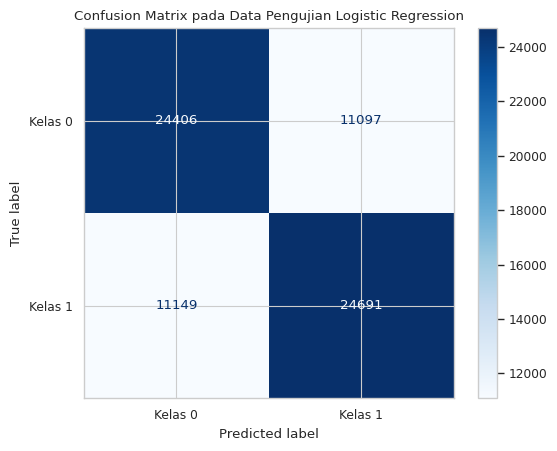

In [83]:
cm_LR = confusion_matrix(y_test, y_test_pred_LR)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_LR, display_labels=['Kelas 0', 'Kelas 1'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix pada Data Pengujian Logistic Regression')
plt.show()

In [84]:
acc_LR_train=round(LR.score(x_train,y_train)*100,2)
acc_LR_test=round(LR.score(x_test,y_test)*100,2)
error_LR = round(acc_LR_test - acc_LR_train,2)
print("Training Accuracy: {} %".format(acc_LR_train))
print("Testing Accuracy: {} %".format(acc_LR_test))
print("Error: {} %".format(abs(error_LR)))

Training Accuracy: 68.86 %
Testing Accuracy: 68.82 %
Error: 0.04 %


In [85]:
# ROC scores
roc_auc_LR = round(roc_auc_score(y_test, y_test_pred_proba_LR),4)
print('ROC AUC:', roc_auc_LR)

ROC AUC: 0.7517


SVM

In [86]:
base_svm = LinearSVC(
    C=0.1,                    # Regularisasi kecil untuk kecepatan
    class_weight='balanced',  # Tangani ketidakseimbangan kelas
    random_state=42,
    max_iter=1000,            # Batasi iterasi optimasi
    tol=1e-3                  # Toleransi besar untuk konvergensi cepat
)
SVM = CalibratedClassifierCV(base_svm, cv=3, method='sigmoid')
SVM.fit(x_train, y_train)

y_train_pred_SVM=SVM.predict(x_train)

print('Classificatian Report SVM:\n')
print(classification_report(y_train, y_train_pred_SVM))

Classificatian Report SVM:

              precision    recall  f1-score   support

           0       0.69      0.69      0.69    142854
           1       0.69      0.69      0.69    142517

    accuracy                           0.69    285371
   macro avg       0.69      0.69      0.69    285371
weighted avg       0.69      0.69      0.69    285371



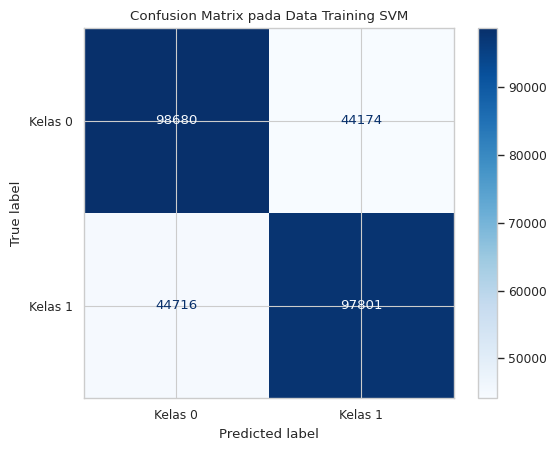

In [87]:
cm_SVM = confusion_matrix(y_train, y_train_pred_SVM)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_SVM, display_labels=['Kelas 0', 'Kelas 1'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix pada Data Training SVM')
plt.show()

In [88]:

y_test_pred_proba_SVM = SVM.predict_proba(x_test)[:, 1]
y_test_pred_SVM=SVM.predict(x_test)

print('Classificatian Report SVM:\n')
print(classification_report(y_test, y_test_pred_SVM))

Classificatian Report SVM:

              precision    recall  f1-score   support

           0       0.69      0.69      0.69     35503
           1       0.69      0.69      0.69     35840

    accuracy                           0.69     71343
   macro avg       0.69      0.69      0.69     71343
weighted avg       0.69      0.69      0.69     71343



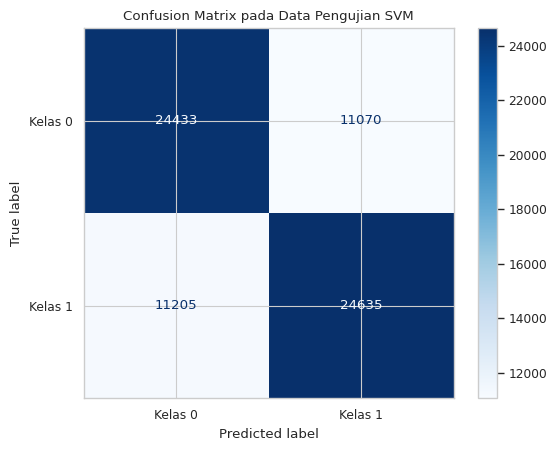

In [89]:
cm_SVM = confusion_matrix(y_test, y_test_pred_SVM)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_SVM, display_labels=['Kelas 0', 'Kelas 1'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix pada Data Pengujian SVM')
plt.show()

In [90]:
acc_SVM_train=round(SVM.score(x_train,y_train)*100,2)
acc_SVM_test=round(SVM.score(x_test,y_test)*100,2)
error_SVM = round(acc_SVM_test - acc_SVM_train,2)
print("Training Accuracy: {} %".format(acc_SVM_train))
print("Testing Accuracy: {} %".format(acc_SVM_test))
print("Error: {} %".format(abs(error_SVM)))

Training Accuracy: 68.85 %
Testing Accuracy: 68.78 %
Error: 0.07 %


In [91]:
# ROC scores
roc_auc_SVM = round(roc_auc_score(y_test, y_test_pred_proba_SVM),4)
print('ROC AUC:', roc_auc_SVM)

ROC AUC: 0.7517


KNN

In [92]:
KNN=KNeighborsClassifier(n_neighbors=5)
KNN.fit(x_train,y_train)

y_train_pred_KNN=KNN.predict(x_train)

print('Classificatian Report KNN:\n')
print(classification_report(y_train, y_train_pred_KNN))

Classificatian Report KNN:

              precision    recall  f1-score   support

           0       0.96      0.85      0.90    142854
           1       0.87      0.96      0.91    142517

    accuracy                           0.91    285371
   macro avg       0.91      0.91      0.91    285371
weighted avg       0.91      0.91      0.91    285371



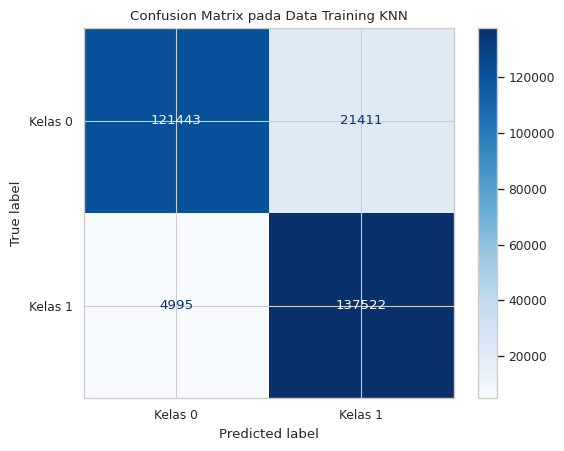

In [93]:
cm_KNN = confusion_matrix(y_train, y_train_pred_KNN)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_KNN, display_labels=['Kelas 0', 'Kelas 1'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix pada Data Training KNN')
plt.show()

In [94]:
y_test_pred_proba_KNN = KNN.predict_proba(x_test)[:, 1]
y_test_pred_KNN=KNN.predict(x_test)

print('Classificatian Report KNN:\n')
print(classification_report(y_test, y_test_pred_KNN))

Classificatian Report KNN:

              precision    recall  f1-score   support

           0       0.92      0.78      0.84     35503
           1       0.81      0.93      0.87     35840

    accuracy                           0.85     71343
   macro avg       0.86      0.85      0.85     71343
weighted avg       0.86      0.85      0.85     71343



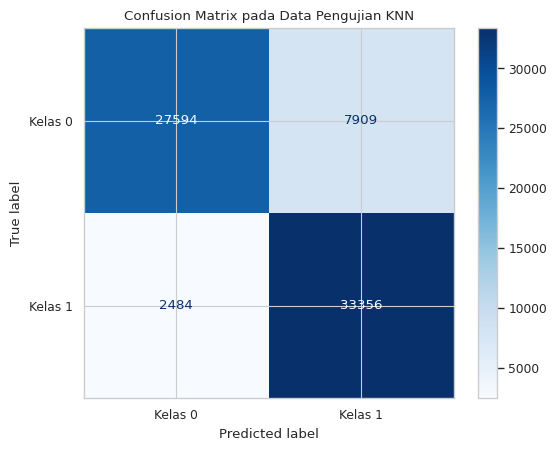

In [95]:
cm_KNN = confusion_matrix(y_test, y_test_pred_KNN)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_KNN, display_labels=['Kelas 0', 'Kelas 1'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix pada Data Pengujian KNN')
plt.show()

In [96]:
acc_KNN_train=round(KNN.score(x_train,y_train)*100,2)
acc_KNN_test=round(KNN.score(x_test,y_test)*100,2)
error_KNN = round(acc_KNN_test - acc_KNN_train,2)
print("Training Accuracy: {} %".format(acc_KNN_train))
print("Testing Accuracy: {} %".format(acc_KNN_test))
print("Error: {} %".format(abs(error_KNN)))

Training Accuracy: 90.75 %
Testing Accuracy: 85.43 %
Error: 5.32 %


In [97]:
# ROC scores
roc_auc_KNN = round(roc_auc_score(y_test, y_test_pred_proba_KNN),4)
print('ROC AUC:', roc_auc_KNN)

ROC AUC: 0.9339


## Model Evaluation

In [98]:
results = pd.DataFrame([["Random Forest", acc_RF_train, acc_RF_test, error_RF, roc_auc_RF],["XGB", acc_XGB_train, acc_XGB_test, error_XGB, roc_auc_XGB],
                       ["LGB", acc_LGB_train, acc_LGB_test, error_LGB, roc_auc_LGB],["CATBOOST", acc_CB_train, acc_CB_test, error_CB, roc_auc_CB],
                       ["LOGISTIC REGRESSION", acc_LR_train, acc_LR_test, error_LR, roc_auc_LR], ["SVM", acc_SVM_train, acc_SVM_test, error_SVM, roc_auc_SVM],
                        ["KNN", acc_KNN_train, acc_KNN_test, error_KNN, roc_auc_KNN]],
                       columns = ["Models", "Training Accuracy Score", "Testing Accuracy Score", "Error", "ROC Score"])

results.sort_values(by=['Training Accuracy Score', 'Testing Accuracy Score'], ascending=False).style.background_gradient(cmap='Blues')

,Models,Training Accuracy Score,Testing Accuracy Score,Error,ROC Score
0,Random Forest,100.000000,92.660000,-7.340000,0.974400
3,CATBOOST,91.230000,90.860000,-0.370000,0.960000
1,XGB,91.140000,90.230000,-0.910000,0.958400
6,KNN,90.750000,85.430000,-5.320000,0.933900
2,LGB,89.580000,89.340000,-0.240000,0.952500
4,LOGISTIC REGRESSION,68.860000,68.820000,-0.040000,0.751700
5,SVM,68.850000,68.780000,-0.070000,0.751700


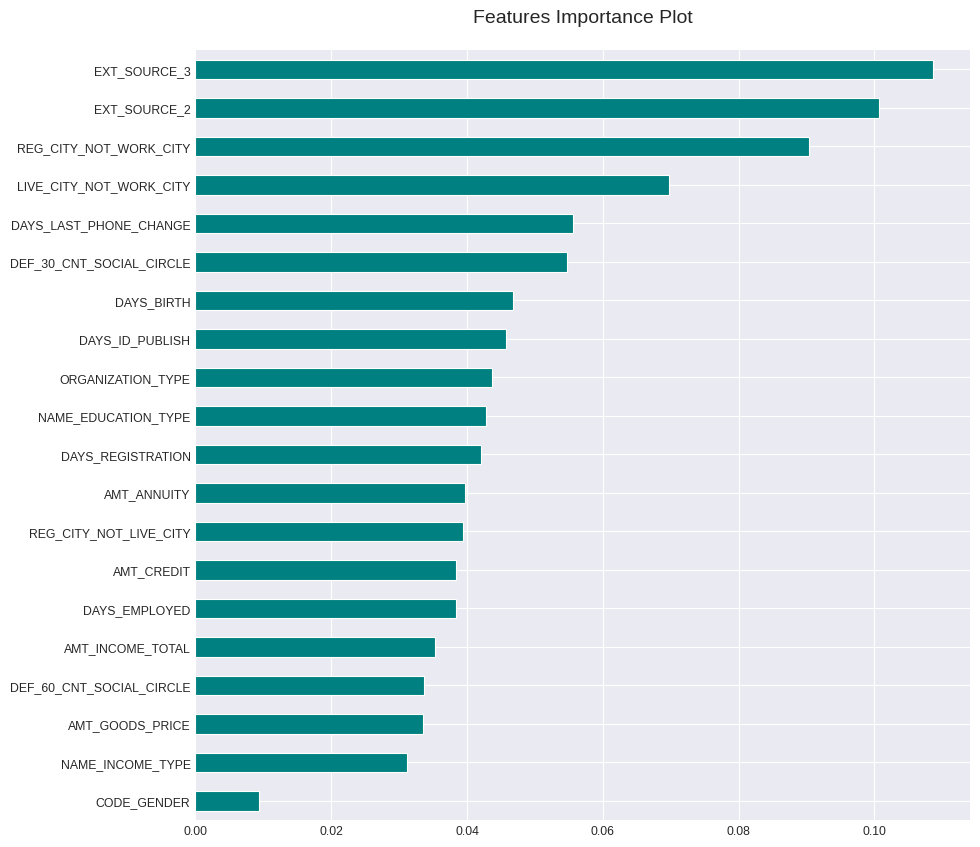

In [99]:
# important features Random Forest Model
importances_rf = pd.Series(RF.feature_importances_, index=X_smote.columns).sort_values(ascending=True)

plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(10,10))
fig = importances_rf.plot(kind ='barh', color ='teal')
plt.title('Features Importance Plot\n', fontsize=14)
plt.show()

fig.figure.tight_layout()
fig.figure.savefig('top feature.png')

## Prediction

In [110]:


# === Load Data ===
test_data = pd.read_csv("application_test.csv")
# Simpan SK_ID_CURR
sk_id_curr = test_data['SK_ID_CURR']

# === Gabungkan data train dan test untuk one-hot encoding konsisten ===
x['is_train'] = 1
test_data['is_train'] = 0
combined = pd.concat([x, test_data], ignore_index=True)

# Identifikasi kolom kategorikal
categorical_cols = combined.select_dtypes(include=['object', 'category']).columns.tolist()

# One-hot encoding
combined_encoded = pd.get_dummies(combined, columns=categorical_cols, drop_first=True)
combined_encoded = combined_encoded.fillna(0)


# Pisahkan kembali data train dan test setelah encoding
x_encoded = combined_encoded[combined_encoded['is_train'] == 1].drop(columns=['is_train', 'SK_ID_CURR'])
test_data_encoded = combined_encoded[combined_encoded['is_train'] == 0].drop(columns=['is_train', 'SK_ID_CURR'])

# === Feature Selection dengan SelectKBest ===
# Chi2 memerlukan nilai non-negatif
if (x_encoded < 0).any().any():
    print("Peringatan: Data mengandung nilai negatif, melakukan penyesuaian.")
    x_non_negative = x_encoded - x_encoded.min()
else:
    x_non_negative = x_encoded

# Pilih 20 fitur terbaik
selector = SelectKBest(score_func=chi2, k=20)
selector.fit(x_non_negative, y)
top_20_features = x_encoded.columns[selector.get_support()].tolist()

X_top = x_encoded[top_20_features]
X_test_top = test_data_encoded[top_20_features]

# === SMOTE (Data balancing) ===
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_top, y)

# === Split Train & Validation ===
X_train, X_val, y_train, y_val = train_test_split(X_smote, y_smote, test_size=0.2, stratify=y_smote, random_state=42)

# === Normalisasi ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_top)

# === Random Forest ===
RF = RandomForestClassifier(
    random_state=42)
RF.fit(X_train, y_train)



RandomForestClassifier(random_state=42)


=== Hasil Validasi ===
Accuracy: 0.7934625681566516
ROC AUC: 0.968381472693413
              precision    recall  f1-score   support

           0       0.96      0.61      0.75     35672
           1       0.71      0.98      0.83     35671

    accuracy                           0.79     71343
   macro avg       0.84      0.79      0.79     71343
weighted avg       0.84      0.79      0.79     71343



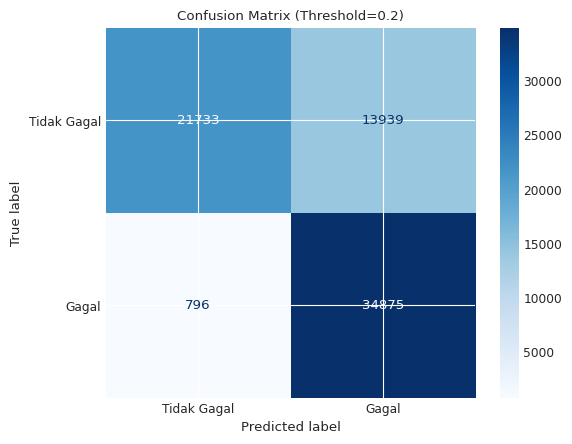

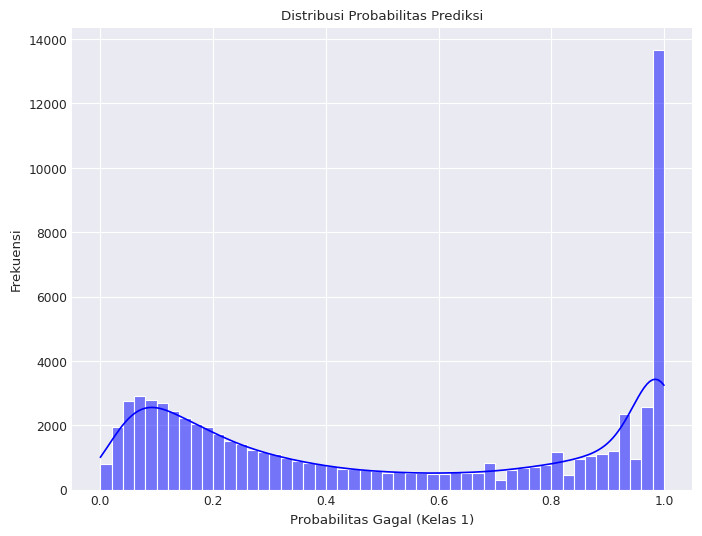


✅ Prediksi disimpan ke predictions_rf.csv


,SK_ID_CURR,Predicted,Probability_Class_1
0,100001,1,0.35
1,100005,1,0.36
2,100013,1,0.23
3,100028,0,0.13
4,100038,1,0.41
5,100042,1,0.22
6,100057,1,0.31
7,100065,1,0.36
8,100066,1,0.34
9,100067,1,0.33


In [115]:
from sklearn.metrics import accuracy_score

# === Evaluasi ===
y_val_pred_proba = RF.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_pred_proba >= 0.2).astype(int)

print("\n=== Hasil Validasi ===")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("ROC AUC:", roc_auc_score(y_val, y_val_pred_proba))
print(classification_report(y_val, y_val_pred))

# === Confusion Matrix ===
cm = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(cm, display_labels=['Tidak Gagal', 'Gagal']).plot(cmap='Blues')
plt.title("Confusion Matrix (Threshold=0.2)")
plt.show()

# === Histogram Probabilitas ===
plt.figure(figsize=(8, 6))
sns.histplot(y_val_pred_proba, bins=50, kde=True, color='blue')
plt.title("Distribusi Probabilitas Prediksi")
plt.xlabel("Probabilitas Gagal (Kelas 1)")
plt.ylabel("Frekuensi")
plt.show()

# === Prediksi untuk Data Test ===
y_test_pred_proba = RF.predict_proba(X_test_scaled)[:, 1]
y_test_pred = (y_test_pred_proba >= 0.2).astype(int)

# Simpan hasil ke CSV
result_df = pd.DataFrame({
    'SK_ID_CURR': sk_id_curr,
    'Predicted': y_test_pred,
    'Probability_Class_1': y_test_pred_proba
})
result_df.to_csv("predictions_rf.csv", index=False)
print("\n✅ Prediksi disimpan ke predictions_rf.csv")
result_df.head(10)

In [116]:
!git config --global user.name "Kaisyarendika"
!git config --global user.email "tengkukaisyar13@gmail.com"

In [118]:
!git clone https://github.com/Kaisyarendika/FP_Kaisyarendika.git

Cloning into 'FP_Kaisyarendika'...


In [120]:
!cp "/content/drive/MyDrive/Final Project T Kaisyarendika.ipynb" .

cp: cannot stat '/content/drive/MyDrive/Final Project T Kaisyarendika.ipynb': No such file or directory
